In [ ]:
!nvidia-smi

Mon Jun  6 00:23:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!head /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0


In [ ]:
!head -n 3 /proc/meminfo

MemTotal:       26692024 kB
MemFree:        23537484 kB
MemAvailable:   25416984 kB


In [ ]:
import torch

print(torch.__version__)

1.11.0+cu113


In [ ]:
!cat /etc/issue.net

Ubuntu 18.04.5 LTS


In [ ]:
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hyperparameter

In [ ]:
from datetime import datetime
import torch
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

EPOCHS = 300
BATCHSIZE = 256
SEED = 128
WEIGHTDECAY = 1e-4
LEARNINGRATE = 1e-3
MINLR=1e-7
STEPSIZEUP = 20
GAMMA_CYCLE=0.9
PRINTFREQ = 20
IMGSIZE = (25,18)
DEFAULTPATH='/content/drive/MyDrive/CD1'
MODELPATH='/content/drive/MyDrive/CD1/model'
IMGPATH='/content/drive/MyDrive/CD1/img'

MEAN = (0.4914, 0.4822, 0.4465)
STD = (0.2023, 0.1994, 0.2010)

# Only for cifar-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
NUMCLASSES=len(classes)

ALPHA1 = 0.7 ### cutmix alpha
ALPHA2 = 1.2 ### mixup alpha

LAMBDA1=0.9
LAMBDA2=0.7
LAMBDA3=0.7

def fix_seed():
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    np.random.seed(SEED)

def device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Augments

In [ ]:
# -*- coding: utf-8 -*-


import numpy as np
import torch
import torch.nn.functional as F

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def rand_bbox(size, lam): # size : [B, C, W, H]
    W = size[2] # 이미지의 width
    H = size[3] # 이미지의 height
    cut_rat = np.sqrt(1. - lam)  # 패치 크기의 비율 정하기
    cut_w = int(W * cut_rat)  # 패치의 너비
    cut_h = int(H * cut_rat)  # 패치의 높이

    # 기존 이미지의 크기에서 랜덤하게 중간 좌표 추출
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # 패치 부분에 대한 좌표값을 추출합니다.
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


# Dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

### define parameter

batch_size = BATCHSIZE
mean = MEAN
std = STD

### gpu 사용여부
device = torch.device('cuda')
IsGPU = device==torch.device('cuda')
print(IsGPU)

### seed 고정
fix_seed()

### transformer

transform = transforms.Compose([
            ### cifar 10 size는 (32,32) 이므로 resize해줄 필요는 없음.
            transforms.ToTensor(),
            # transforms.Resize((256,256)),### 사진을 보기 위해서 임의로 resize했습니다.
            transforms.Normalize(mean, std)
])



trainset = torchvision.datasets.CIFAR10(root=f'{DEFAULTPATH}/train/', train=True,
                                        download=True, transform=transform)

train_size = int(len(trainset)*0.9)
validation_size = int(len(trainset)*0.1)

### train validation set 분리
trainset, validationset = torch.utils.data.random_split(trainset,[train_size,validation_size])

testset = torchvision.datasets.CIFAR10(root=f'{DEFAULTPATH}/test/', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validationloader = torch.utils.data.DataLoader(validationset,batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False,  num_workers=2)

True
Files already downloaded and verified
Files already downloaded and verified


# Utils

In [ ]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

# Resnet18


## Model

In [ ]:
### https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
import torch
import torch.nn as nn
from torch.utils.model_zoo import load_url as load_state_dict_from_url
import time

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, # the first layer uses fp weights
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes) # the last layer uses fp weights

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

def resnet18():
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    return model

## MODELNAME

In [ ]:
MODELNAME = 'resnet18'

## Train & Validation

In [ ]:
### main
def main_main():
    model = resnet18()

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = main_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = main_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    
    


def main_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if i % np.random.randint(1,6) == 0:
            temp_X_1 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            temp_X_2 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            lam1 = LAMBDA1
            lam2 = LAMBDA2
            lam3 = LAMBDA3
            rand_index = torch.randperm(input.size()[0]).cuda() if IsGPU else torch.randperm(input.size()[0])
            shuffled_y = target[rand_index]

            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam1)
            input[:,:,bbx1:bbx2, bby1:bby2] = input[shuffled_y,:,bbx1:bbx2, bby1:bby2]
            temp_X_2[:,:,:,:]=temp_X_2[shuffled_y,:,:,:]
            lam1 = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
            mixed_1 = lam2 * input + (1 - lam2) * temp_X_1
            mixed_1 = mixed_1.cuda() if IsGPU else mixed_1
            mixed_2 = lam3 * mixed_1 + (1 - lam3) * temp_X_2
            mixed_2 = mixed_2.cuda() if IsGPU else mixed_2

            # compute output
            output = model(mixed_2)
            loss = mixup_criterion(criterion,output,target,shuffled_y,lam1*lam2*lam3+(1-lam2)*lam3)

        else:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def main_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg


In [ ]:
### main
def cutmixup_main():
    model = resnet18()

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)   
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = cutmixup_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = cutmixup_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}_cutmixup.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    
    


def cutmixup_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if i % np.random.randint(1,6) == 0:
            temp_X_1 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            temp_X_2 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            lam1 = LAMBDA1
            lam2 = LAMBDA2
            rand_index = torch.randperm(input.size()[0]).cuda() if IsGPU else torch.randperm(input.size()[0])
            shuffled_y = target[rand_index]
            temp_X_2[:,:,:,:]=temp_X_2[shuffled_y,:,:,:]
            mixed_1 = lam2 * input + (1 - lam2) * temp_X_2
            mixed_1 = mixed_1.cuda() if IsGPU else mixed_1


            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam1)
            input[:,:,bbx1:bbx2, bby1:bby2] = mixed_1[:,:,bbx1:bbx2, bby1:bby2]
            lam1 = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))

            # compute output
            output = model(input)
            loss = mixup_criterion(criterion,output,target,shuffled_y,1-lam2+lam1*lam2)

        else:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def cutmixup_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg


In [ ]:
# -*- coding: utf-8 -*-
###original
def ori_main():
    model = resnet18()

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)   
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = ori_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = ori_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}_original.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    
    


def ori_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        input = input.cuda() if IsGPU else input
        target = target.cuda() if IsGPU else target

        output = model(input)
        loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def ori_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg


In [ ]:
def mixup_main():
    model = resnet18()

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = mixup_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = mixup_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}_mixup.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")
    

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    


def mixup_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if i % np.random.randint(1,6) == 0:
            temp_X_1 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            lam2 = LAMBDA2
            rand_index = torch.randperm(input.size()[0]).cuda() if IsGPU else torch.randperm(input.size()[0])
            shuffled_y = target[rand_index]

            temp_X_1[:,:,:,:]=temp_X_1[shuffled_y,:,:,:]
            mixed_1 = lam2 * input + (1 - lam2) * temp_X_1
            mixed_1 = mixed_1.cuda() if IsGPU else mixed_1

            # compute output
            output = model(mixed_1)
            loss = mixup_criterion(criterion,output,target,shuffled_y,lam2)

        else:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def mixup_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg



In [ ]:
def cutmix_main():
    model = resnet18()

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = cutmix_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = cutmix_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}_cutmix.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    
    


def cutmix_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if i % np.random.randint(1,6) == 0:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target
            
            lam1 = LAMBDA1
            rand_index = torch.randperm(input.size()[0]).cuda() if IsGPU else torch.randperm(input.size()[0])
            shuffled_y = target[rand_index] 

            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam1)
            input[:,:,bbx1:bbx2, bby1:bby2] = input[shuffled_y,:,bbx1:bbx2, bby1:bby2]
            lam1 = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))

            # compute output
            output = model(input)
            loss = mixup_criterion(criterion,output,target,shuffled_y,lam1)

        else:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def cutmix_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg


## Run

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

Epoch: [22][ 0/20]	Time  0.150 ( 0.150)	Data  0.139 ( 0.139)	Loss 1.2757e+00 (1.2757e+00)	Acc@1  65.23 ( 65.23)	Acc@5  96.48 ( 96.48)
=> Acc@1 63.000 Acc@5 94.000
==> 0.68 seconds to validate this epoch


----- epoch: 23, lr: 0.000850015 -----
Epoch: [23][  0/176]	Time  0.203 ( 0.203)	Data  0.153 ( 0.153)	Loss 2.9970e-01 (2.9970e-01)	Acc@1  95.70 ( 95.70)	Acc@5  99.61 ( 99.61)
Epoch: [23][ 20/176]	Time  0.037 ( 0.041)	Data  0.003 ( 0.011)	Loss 6.4304e-01 (3.2228e-01)	Acc@1  90.62 ( 93.47)	Acc@5 100.00 ( 99.98)
Epoch: [23][ 40/176]	Time  0.031 ( 0.036)	Data  0.003 ( 0.007)	Loss 5.6000e-01 (3.5796e-01)	Acc@1  91.80 ( 93.36)	Acc@5 100.00 ( 99.95)
Epoch: [23][ 60/176]	Time  0.051 ( 0.035)	Data  0.016 ( 0.006)	Loss 5.7742e-01 (3.5425e-01)	Acc@1  95.70 ( 93.43)	Acc@5 100.00 ( 99.95)
Epoch: [23][ 80/176]	Time  0.033 ( 0.035)	Data  0.007 ( 0.006)	Loss 1.8859e-01 (3.5098e-01)	Acc@1  94.92 ( 93.43)	Acc@5 100.00 ( 99.95)
Epoch: [23][100/176]	Time  0.039 ( 0.03

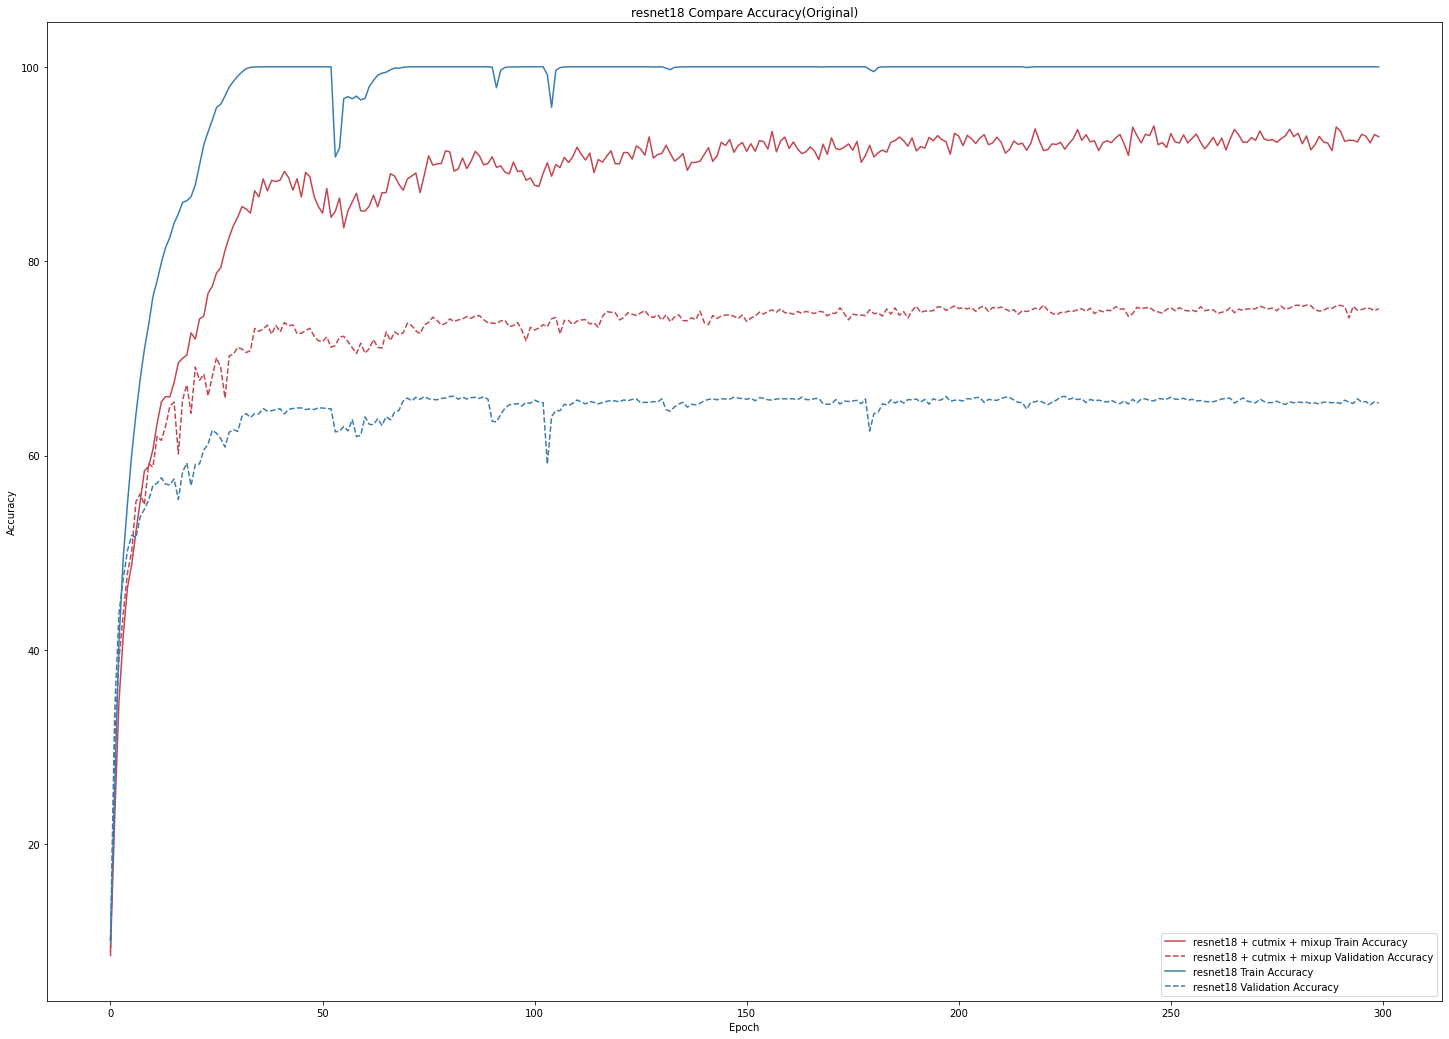

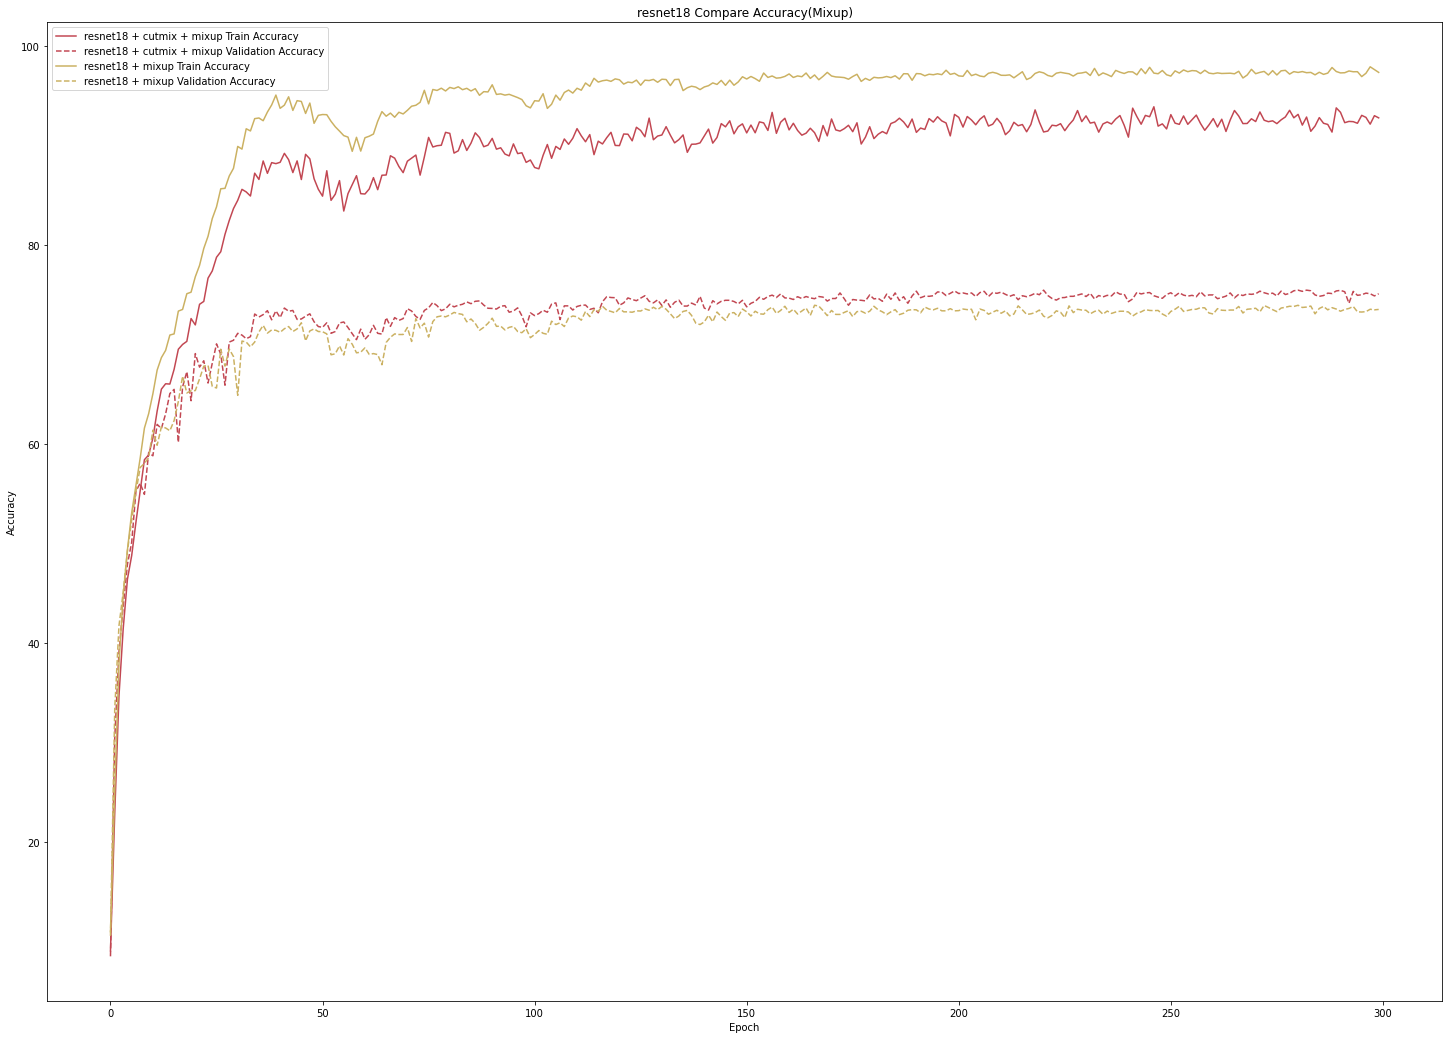

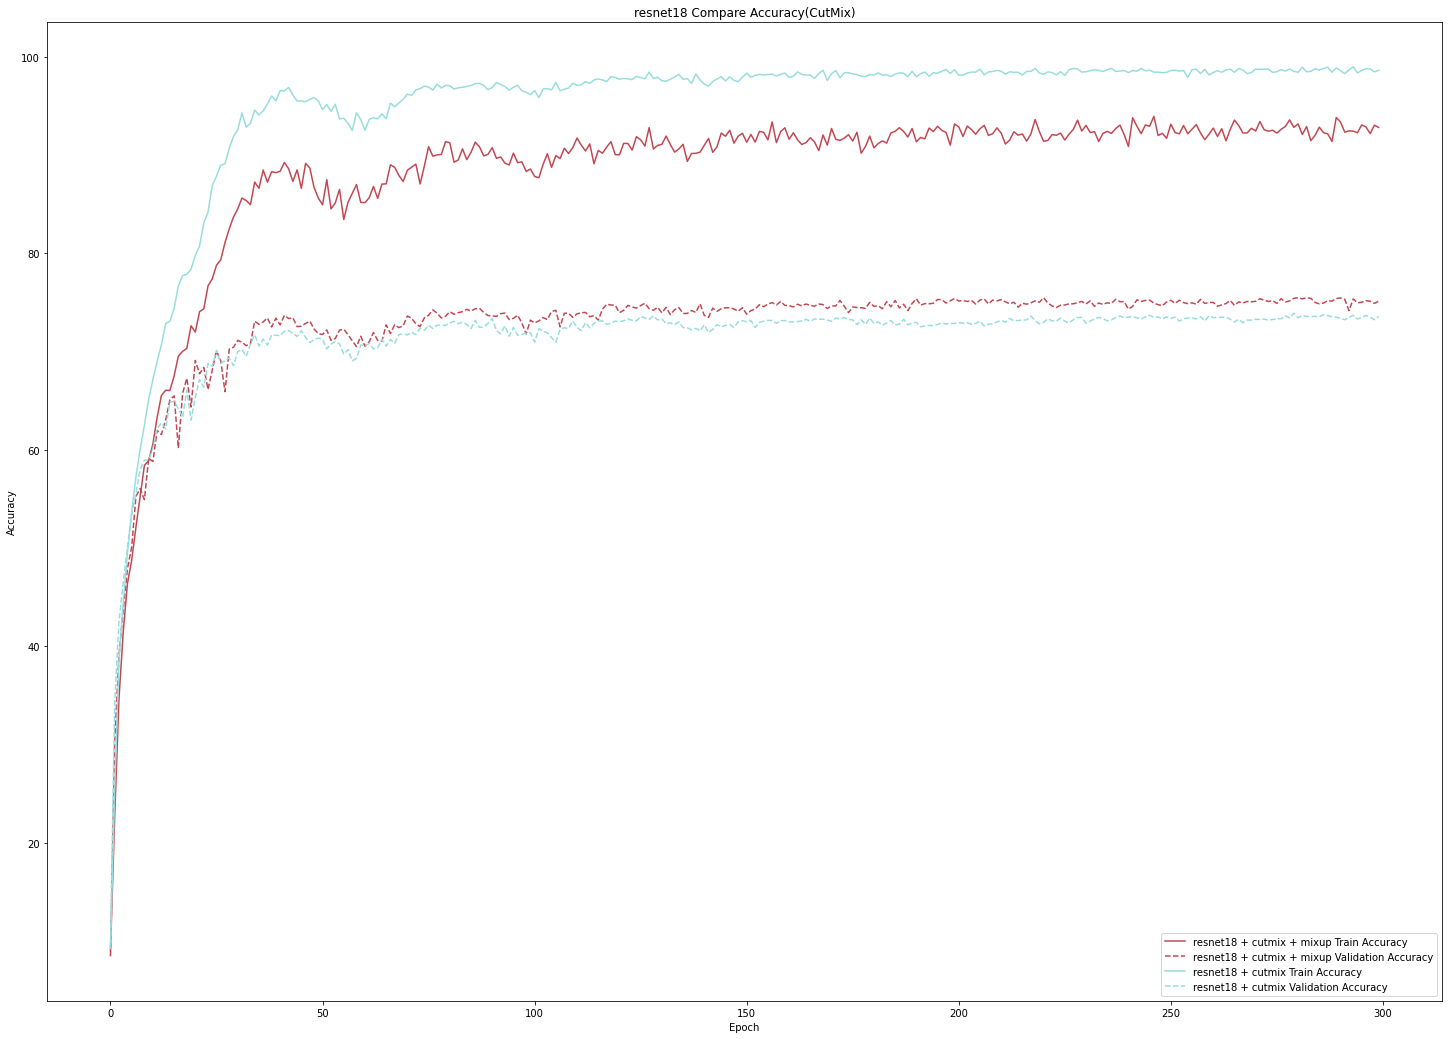

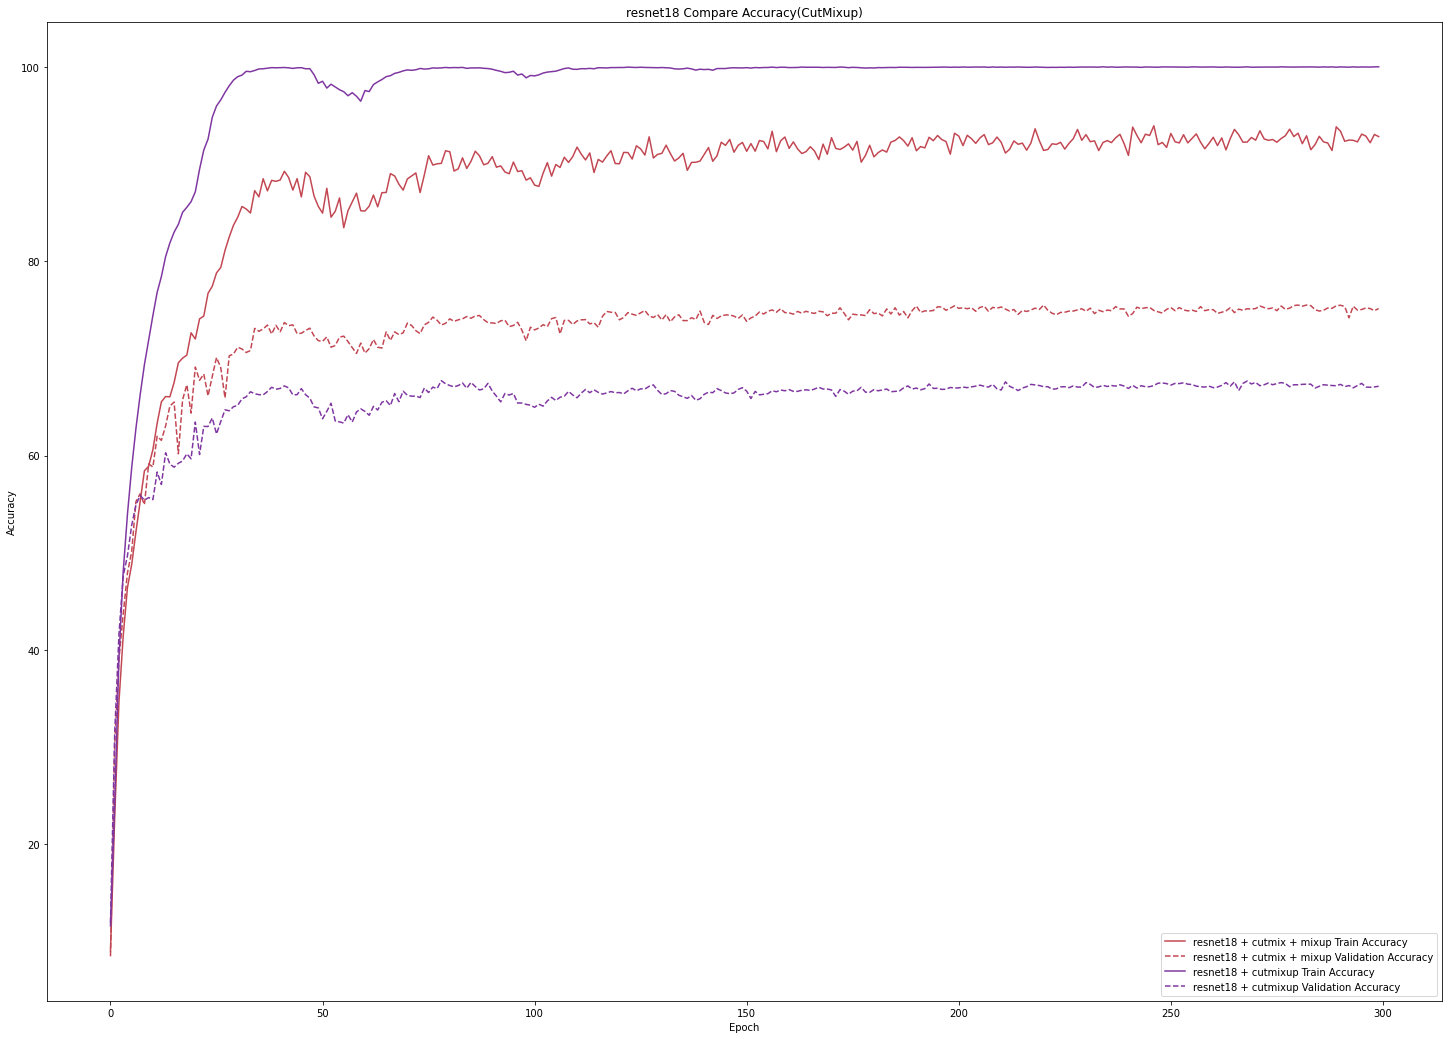

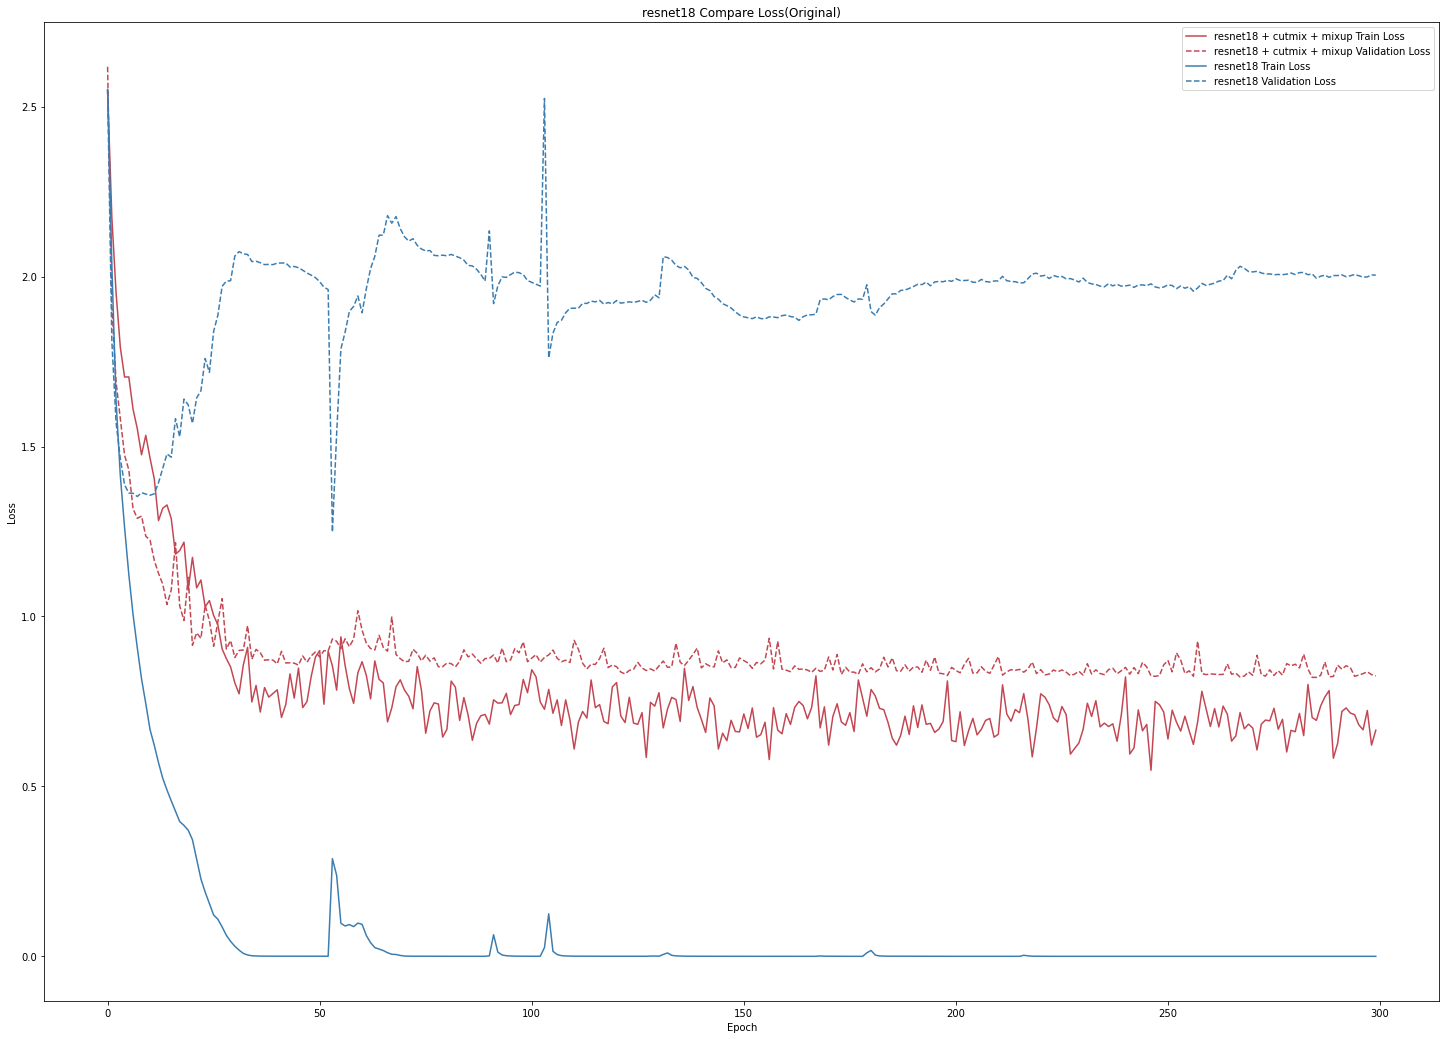

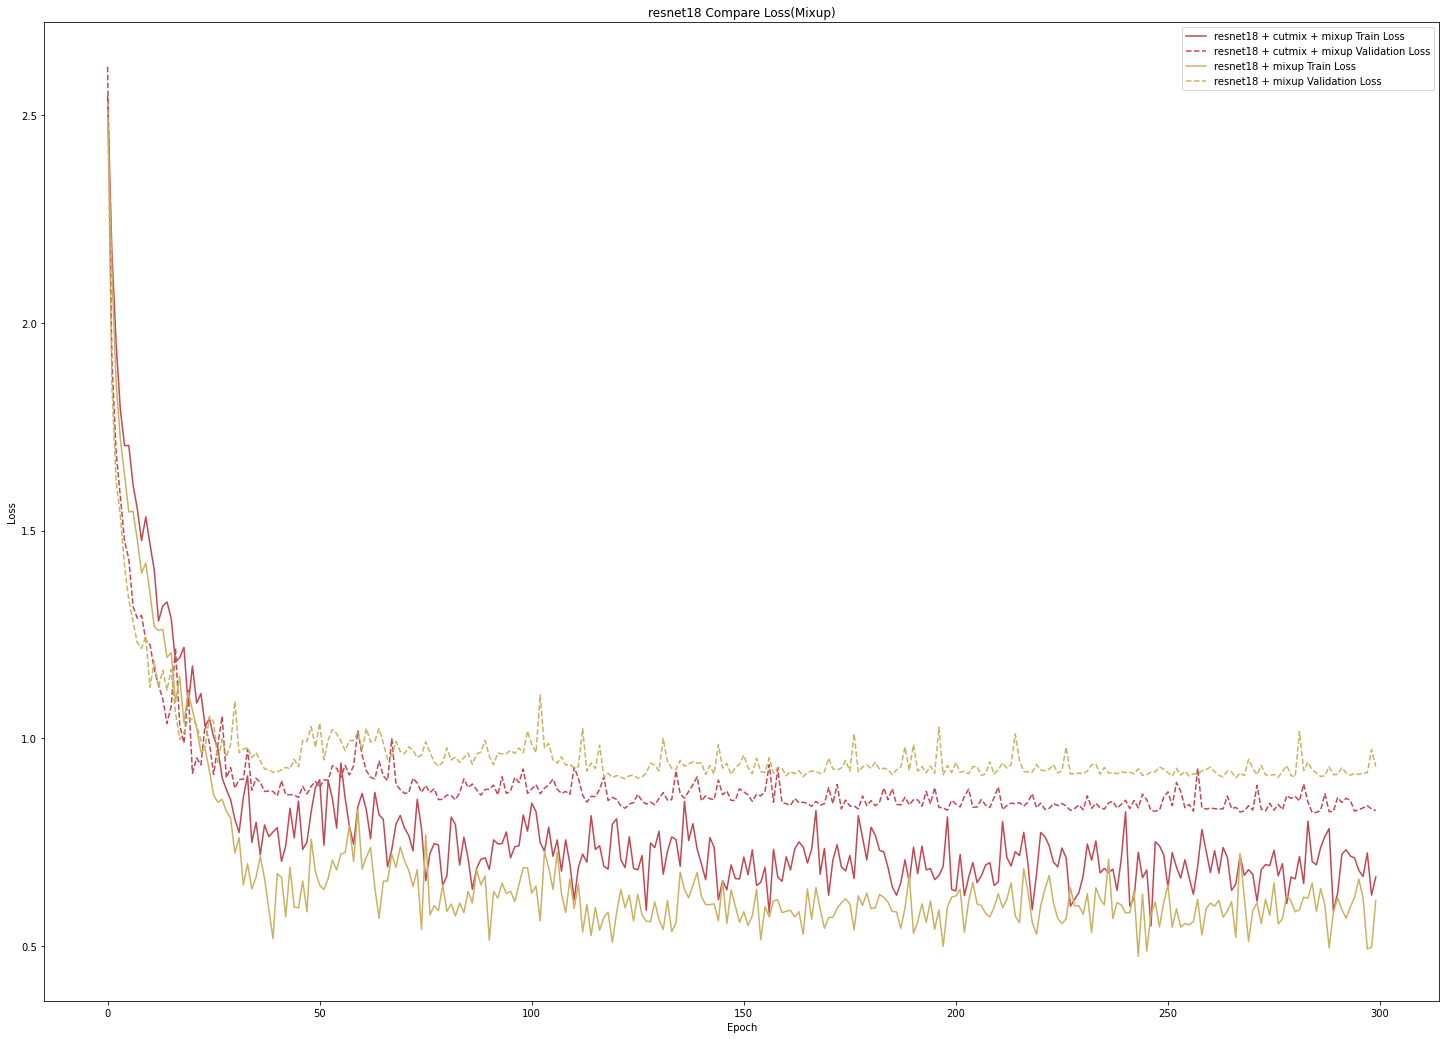

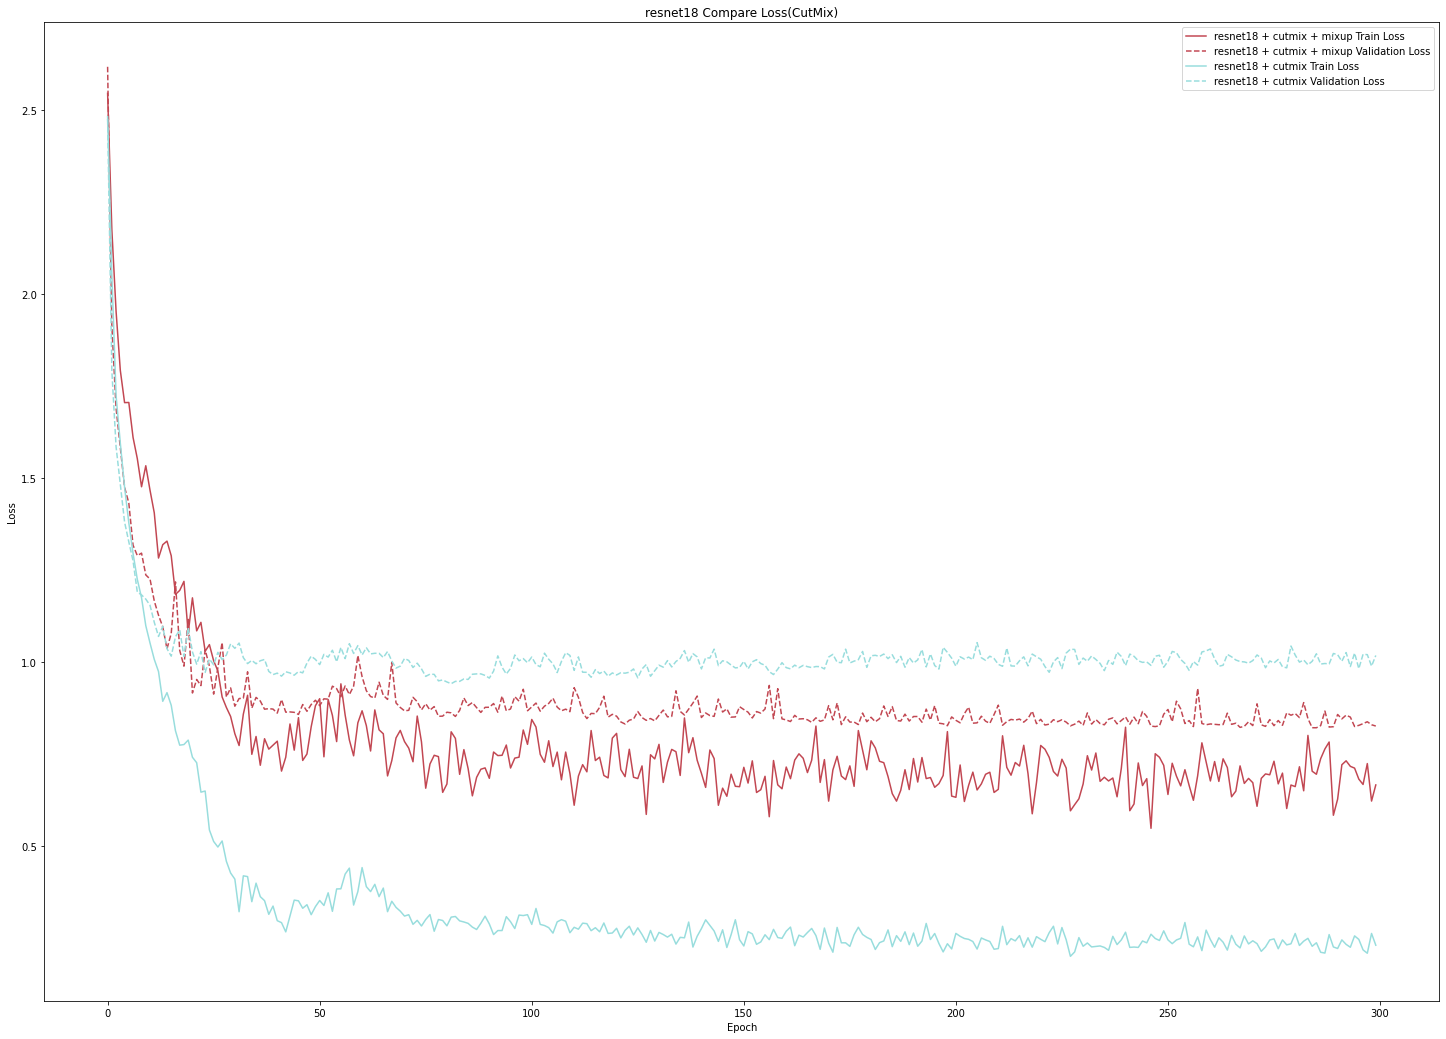

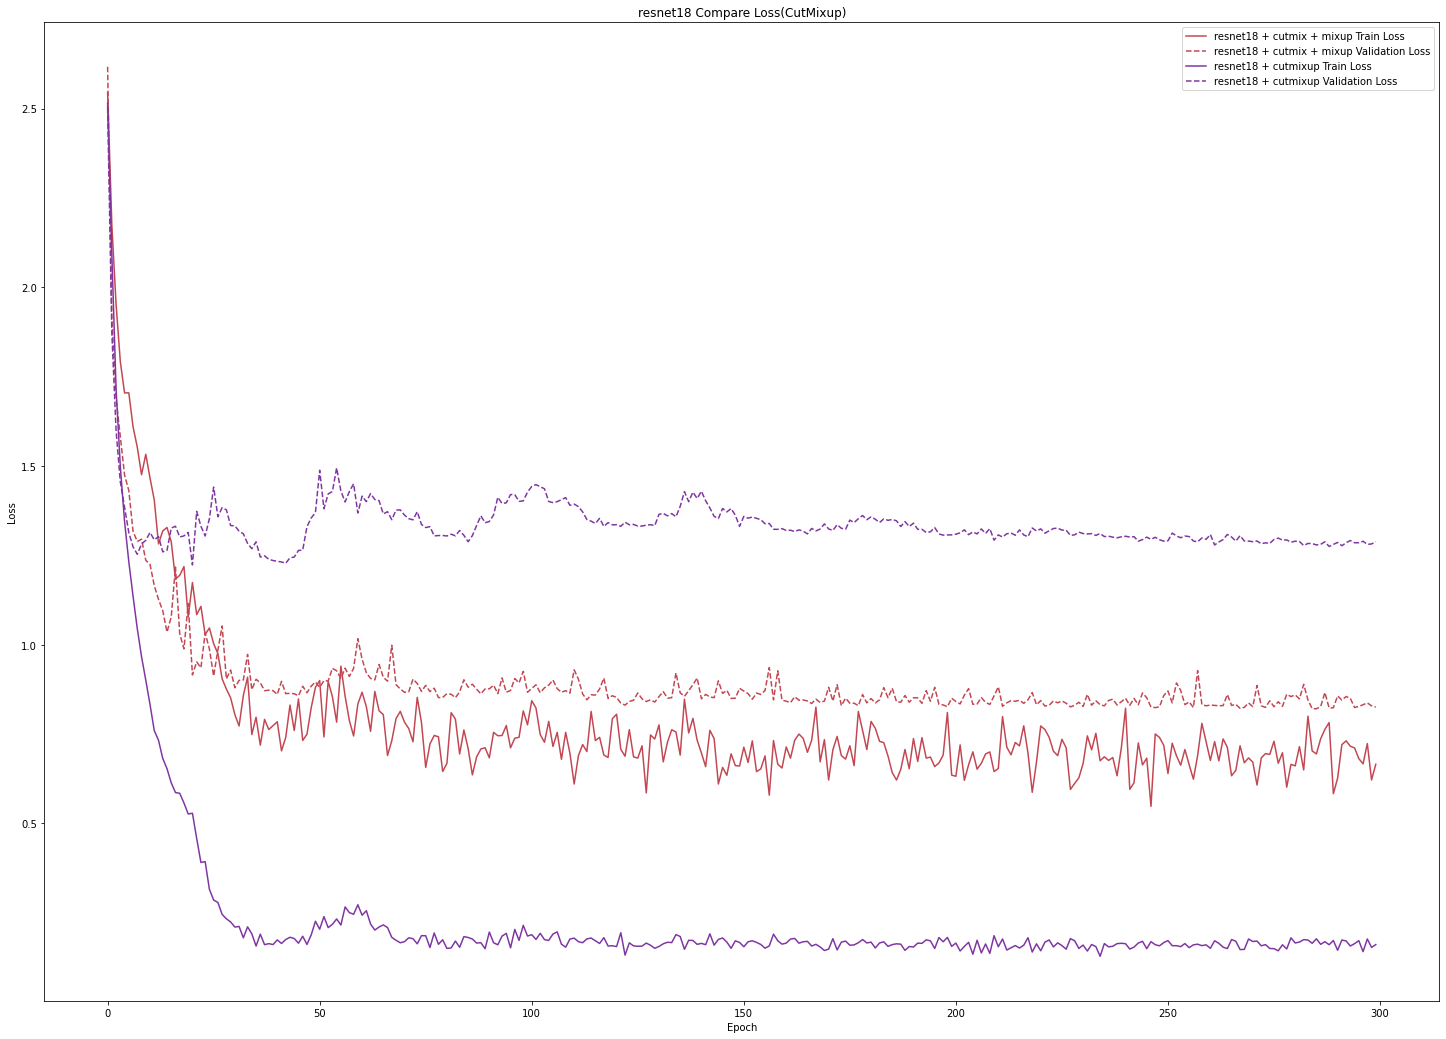

In [ ]:
print("--main--")
main_train_last_top1_acc,main_val_last_top1_acc,main_pytorch_total_params,main_train_loss_history,main_train_correct_history,main_validation_loss_history,main_validation_correct_history=main_main()
print("--ori--")
original_train_last_top1_acc,original_val_last_top1_acc,original_pytorch_total_params,original_train_loss_history,original_train_correct_history,original_validation_loss_history,original_validation_correct_history=ori_main()
print("--mixup--")
mixup_train_last_top1_acc,mixup_val_last_top1_acc,mixup_pytorch_total_params,mixup_train_loss_history,mixup_train_correct_history,mixup_validation_loss_history,mixup_validation_correct_history=mixup_main()
print("--cutmix--")
cutmix_train_last_top1_acc,cutmix_val_last_top1_acc,cutmix_pytorch_total_params,cutmix_train_loss_history,cutmix_train_correct_history,cutmix_validation_loss_history,cutmix_validation_correct_history=cutmix_main()
print("--cutmixup--")
cutmixup_train_last_top1_acc,cutmixup_val_last_top1_acc,cutmixup_pytorch_total_params,cutmixup_train_loss_history,cutmixup_train_correct_history,cutmixup_validation_loss_history,cutmixup_validation_correct_history=cutmixup_main()

print ("{:<30} {:<30} {:<30} {:<30}".format('Model','Train Last Top1 Accuracy','Validation Last Top1 Accuracy','Total Parameters'))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}',original_train_last_top1_acc,original_val_last_top1_acc,original_pytorch_total_params))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}+cutmix',cutmix_train_last_top1_acc,cutmix_val_last_top1_acc,cutmix_pytorch_total_params))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}+mixup',mixup_train_last_top1_acc,mixup_val_last_top1_acc,mixup_pytorch_total_params))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}+cutmixup',cutmixup_train_last_top1_acc,cutmixup_val_last_top1_acc,cutmixup_pytorch_total_params))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}+cutmix+mixup',main_train_last_top1_acc,main_val_last_top1_acc,main_pytorch_total_params))


X1 = np.arange(len(main_train_correct_history))
train_y1 = np.array(main_train_correct_history)
val_y1 = np.array(main_validation_correct_history)
train_ori_y1 = np.array(original_train_correct_history)
val_ori_y1 = np.array(original_validation_correct_history)
train_mixup_y1 = np.array(mixup_train_correct_history)
val_mixup_y1 = np.array(mixup_validation_correct_history)
train_cutmix_y1 = np.array(cutmix_train_correct_history)
val_cutmix_y1 = np.array(cutmix_validation_correct_history)
train_cutmixup_y1 = np.array(cutmixup_train_correct_history)
val_cutmixup_y1 = np.array(cutmixup_validation_correct_history)

X2 = np.arange(len(main_train_loss_history))
train_y2 = np.array(main_train_loss_history)
val_y2 = np.array(main_validation_loss_history)
train_ori_y2 = np.array(original_train_loss_history)
val_ori_y2 = np.array(original_validation_loss_history)
train_mixup_y2 = np.array(mixup_train_loss_history)
val_mixup_y2 = np.array(mixup_validation_loss_history)
train_cutmix_y2 = np.array(cutmix_train_loss_history)
val_cutmix_y2 = np.array(cutmix_validation_loss_history)
train_cutmixup_y2 = np.array(cutmixup_train_loss_history)
val_cutmixup_y2 = np.array(cutmixup_validation_loss_history)


plt.figure(1,figsize=IMGSIZE)
plt.plot(X1,train_y1,label=f"{MODELNAME} + cutmix + mixup Train Accuracy",color='#C24752', linestyle='-')
plt.plot(X1,val_y1,label=f"{MODELNAME} + cutmix + mixup Validation Accuracy",color='#C24752', linestyle='--')
plt.plot(X1,train_ori_y1,label=f"{MODELNAME} Train Accuracy",color='#3B7DB0', linestyle='-')
plt.plot(X1,val_ori_y1,label=f"{MODELNAME} Validation Accuracy",color='#3B7DB0', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{MODELNAME} Compare Accuracy(Original)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Accuracy_Original.png")

plt.figure(2,figsize=IMGSIZE)
plt.plot(X1,train_y1,label=f"{MODELNAME} + cutmix + mixup Train Accuracy",color='#C24752', linestyle='-')
plt.plot(X1,val_y1,label=f"{MODELNAME} + cutmix + mixup Validation Accuracy",color='#C24752', linestyle='--')
plt.plot(X1,train_mixup_y1,label=f"{MODELNAME} + mixup Train Accuracy",color='#CBB162', linestyle='-')
plt.plot(X1,val_mixup_y1,label=f"{MODELNAME} + mixup Validation Accuracy",color='#CBB162', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{MODELNAME} Compare Accuracy(Mixup)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Accuracy_Mixup.png")

plt.figure(3,figsize=IMGSIZE)
plt.plot(X1,train_y1,label=f"{MODELNAME} + cutmix + mixup Train Accuracy",color='#C24752', linestyle='-')
plt.plot(X1,val_y1,label=f"{MODELNAME} + cutmix + mixup Validation Accuracy",color='#C24752', linestyle='--')
plt.plot(X1,train_cutmix_y1,label=f"{MODELNAME} + cutmix Train Accuracy",color='#98DDDD', linestyle='-')
plt.plot(X1,val_cutmix_y1,label=f"{MODELNAME} + cutmix Validation Accuracy",color='#98DDDD', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{MODELNAME} Compare Accuracy(CutMix)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Accuracy_CutMix.png")

plt.figure(4,figsize=IMGSIZE)
plt.plot(X1,train_y1,label=f"{MODELNAME} + cutmix + mixup Train Accuracy",color='#C24752', linestyle='-')
plt.plot(X1,val_y1,label=f"{MODELNAME} + cutmix + mixup Validation Accuracy",color='#C24752', linestyle='--')
plt.plot(X1,train_cutmixup_y1,label=f"{MODELNAME} + cutmixup Train Accuracy",color='#7F36A1', linestyle='-')
plt.plot(X1,val_cutmixup_y1,label=f"{MODELNAME} + cutmixup Validation Accuracy",color='#7F36A1', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{MODELNAME} Compare Accuracy(CutMixup)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Accuracy_CutMixup.png")

plt.figure(5,figsize=IMGSIZE)
plt.plot(X2,train_y2,label=f"{MODELNAME} + cutmix + mixup Train Loss",color='#C24752', linestyle='-')
plt.plot(X2,val_y2,label=f"{MODELNAME} + cutmix + mixup Validation Loss",color='#C24752', linestyle='--')
plt.plot(X2,train_ori_y2,label=f"{MODELNAME} Train Loss",color='#3B7DB0', linestyle='-')
plt.plot(X2,val_ori_y2,label=f"{MODELNAME} Validation Loss",color='#3B7DB0', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{MODELNAME} Compare Loss(Original)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Loss_Original.png")

plt.figure(6,figsize=IMGSIZE)
plt.plot(X2,train_y2,label=f"{MODELNAME} + cutmix + mixup Train Loss",color='#C24752', linestyle='-')
plt.plot(X2,val_y2,label=f"{MODELNAME} + cutmix + mixup Validation Loss",color='#C24752', linestyle='--')
plt.plot(X2,train_mixup_y2,label=f"{MODELNAME} + mixup Train Loss",color='#CBB162', linestyle='-')
plt.plot(X2,val_mixup_y2,label=f"{MODELNAME} + mixup Validation Loss",color='#CBB162', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{MODELNAME} Compare Loss(Mixup)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Loss_Mixup.png")

plt.figure(7,figsize=IMGSIZE)
plt.plot(X2,train_y2,label=f"{MODELNAME} + cutmix + mixup Train Loss",color='#C24752', linestyle='-')
plt.plot(X2,val_y2,label=f"{MODELNAME} + cutmix + mixup Validation Loss",color='#C24752', linestyle='--')
plt.plot(X2,train_cutmix_y2,label=f"{MODELNAME} + cutmix Train Loss",color='#98DDDD', linestyle='-')
plt.plot(X2,val_cutmix_y2,label=f"{MODELNAME} + cutmix Validation Loss",color='#98DDDD', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{MODELNAME} Compare Loss(CutMix)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Loss_CutMix.png")

plt.figure(8,figsize=IMGSIZE)
plt.plot(X2,train_y2,label=f"{MODELNAME} + cutmix + mixup Train Loss",color='#C24752', linestyle='-')
plt.plot(X2,val_y2,label=f"{MODELNAME} + cutmix + mixup Validation Loss",color='#C24752', linestyle='--')
plt.plot(X2,train_cutmixup_y2,label=f"{MODELNAME} + cutmixup Train Loss",color='#7F36A1', linestyle='-')
plt.plot(X2,val_cutmixup_y2,label=f"{MODELNAME} + cutmixup Validation Loss",color='#7F36A1', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{MODELNAME} Compare Loss(CutMixup)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Loss_CutMixup.png")
    

## Test

In [ ]:
# -*- coding: utf-8 -*-

# import argparse
from random import sample
import pandas as pd


def eval():
    model1 = resnet18()
    model2 = resnet18()
    model3 = resnet18()
    model4 = resnet18()
    model5 = resnet18()
    model1 = model1.cuda() if IsGPU else model1
    model2 = model2.cuda() if IsGPU else model2
    model3 = model3.cuda() if IsGPU else model3
    model4 = model4.cuda() if IsGPU else model4
    model5 = model5.cuda() if IsGPU else model5
    model1.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}.pth'))
    model2.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}_cutmix.pth'))
    model3.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}_mixup.pth'))
    model4.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}_original.pth'))
    model5.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}_cutmixup.pth'))
    
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()
    model5.eval()

    total = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0
    correct4 = 0
    correct5 = 0
    print('Evaluate...')
    with torch.no_grad():
        for i, (input, target) in enumerate(testloader):
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target
            output1 = model1(input)
            output2 = model2(input)
            output3 = model3(input)
            output4 = model4(input)
            output5 = model5(input)
            _, predictions1 = torch.max(output1, 1)
            _, predictions2 = torch.max(output2, 1)
            _, predictions3 = torch.max(output3, 1)
            _, predictions4 = torch.max(output4, 1)
            _, predictions5 = torch.max(output5, 1)
            total += target.size(0)
            correct1 += (predictions1 == target).sum().item()
            correct2 += (predictions2 == target).sum().item()
            correct3 += (predictions3 == target).sum().item()
            correct4 += (predictions4 == target).sum().item()
            correct5 += (predictions5 == target).sum().item()
        

    print(f'Accuracy of cutmix and mixup {MODELNAME} on the 10000 test images: {100 * correct1 / total:.2f} %')
    print(f'Accuracy of cutmix {MODELNAME} on the 10000 test images: {100 * correct2 / total:.2f} %')
    print(f'Accuracy of mixup {MODELNAME} on the 10000 test images: {100 * correct3 / total:.2f} %')
    print(f'Accuracy of original {MODELNAME} on the 10000 test images: {100 * correct4 / total:.2f} %')
    print(f'Accuracy of cutmixup {MODELNAME} on the 10000 test images: {100 * correct5 / total:.2f} %')


if __name__ == "__main__":
    eval()

Evaluate...
Accuracy of cutmix and mixup resnet18 on the 10000 test images: 74.95 %
Accuracy of cutmix resnet18 on the 10000 test images: 73.15 %
Accuracy of mixup resnet18 on the 10000 test images: 73.32 %
Accuracy of original resnet18 on the 10000 test images: 65.46 %
Accuracy of cutmixup resnet18 on the 10000 test images: 67.45 %


# DenseNet169


## Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch import Tensor
from torch.jit.annotations import List

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input):
        # type: (List[Tensor]) -> bool
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input):
        # type: (List[Tensor]) -> Tensor
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (List[Tensor]) -> (Tensor)
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (Tensor) -> (Tensor)
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out



def _densenet(arch, growth_rate, block_config, num_init_features, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    return model



def densenet169(progress=True, **kwargs):
    return _densenet('densenet169', 32, (6, 12, 32, 32), 64, progress,
                     **kwargs)


## MODELNAME

In [ ]:
MODELNAME = 'densenet169'

## Train & Validation

In [ ]:
### main
def main_main():
    model = densenet169(num_classes=NUMCLASSES)

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)  
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = main_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = main_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    
    


def main_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if i % np.random.randint(1,6) == 0:
            temp_X_1 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            temp_X_2 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            lam1 = np.random.normal(ALPHA1,0.01)
            lam2 = np.random.beta(ALPHA2,ALPHA2)
            lam3 = np.random.beta(ALPHA2,ALPHA2)
            rand_index = torch.randperm(input.size()[0]).cuda() if IsGPU else torch.randperm(input.size()[0])
            shuffled_y = target[rand_index]

            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam1)
            input[:,:,bbx1:bbx2, bby1:bby2] = input[shuffled_y,:,bbx1:bbx2, bby1:bby2]
            temp_X_2[:,:,:,:]=temp_X_2[shuffled_y,:,:,:]
            lam1 = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
            mixed_1 = lam2 * input + (1 - lam2) * temp_X_1
            mixed_1 = mixed_1.cuda() if IsGPU else mixed_1
            mixed_2 = lam3 * mixed_1 + (1 - lam3) * temp_X_2
            mixed_2 = mixed_2.cuda() if IsGPU else mixed_2

            # compute output
            output = model(mixed_2)
            loss = mixup_criterion(criterion,output,target,shuffled_y,lam1*lam2*lam3+(1-lam2)*lam3)

        else:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def main_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg


In [ ]:
### main
def cutmixup_main():
    model = densenet169(num_classes=NUMCLASSES)

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)   
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = cutmixup_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = cutmixup_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}_cutmixup.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    
    


def cutmixup_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if i % np.random.randint(1,6) == 0:
            temp_X_1 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            temp_X_2 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            lam1 = np.random.normal(ALPHA1,0.01) ##cutmix
            lam2 = np.random.beta(ALPHA2,ALPHA2) ##mixup
            rand_index = torch.randperm(input.size()[0]).cuda() if IsGPU else torch.randperm(input.size()[0])
            shuffled_y = target[rand_index]
            temp_X_2[:,:,:,:]=temp_X_2[shuffled_y,:,:,:]
            mixed_1 = lam2 * input + (1 - lam2) * temp_X_2
            mixed_1 = mixed_1.cuda() if IsGPU else mixed_1


            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam1)
            input[:,:,bbx1:bbx2, bby1:bby2] = mixed_1[:,:,bbx1:bbx2, bby1:bby2]
            lam1 = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))

            # compute output
            output = model(input)
            loss = mixup_criterion(criterion,output,target,shuffled_y,1-lam2+lam1*lam2)

        else:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def cutmixup_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg


In [ ]:
# -*- coding: utf-8 -*-
###original
def ori_main():
    model = densenet169(num_classes=NUMCLASSES)

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)   
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")
    
    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = ori_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = ori_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}_original.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    
    


def ori_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        input = input.cuda() if IsGPU else input
        target = target.cuda() if IsGPU else target

        output = model(input)
        loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def ori_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg


In [ ]:
def mixup_main():
    model = densenet169(num_classes=NUMCLASSES)

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = mixup_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = mixup_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}_mixup.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")
    

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    


def mixup_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if i % np.random.randint(1,6) == 0:
            temp_X_1 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            lam2 = np.random.beta(ALPHA2,ALPHA2)
            rand_index = torch.randperm(input.size()[0]).cuda() if IsGPU else torch.randperm(input.size()[0])
            shuffled_y = target[rand_index]

            temp_X_1[:,:,:,:]=temp_X_1[shuffled_y,:,:,:]
            mixed_1 = lam2 * input + (1 - lam2) * temp_X_1
            mixed_1 = mixed_1.cuda() if IsGPU else mixed_1

            # compute output
            output = model(mixed_1)
            loss = mixup_criterion(criterion,output,target,shuffled_y,lam2)

        else:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def mixup_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg



In [ ]:
def cutmix_main():
    model = densenet169(num_classes=NUMCLASSES)

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = cutmix_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = cutmix_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}_cutmix.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    
    


def cutmix_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if i % np.random.randint(1,6) == 0:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            lam1 = np.random.normal(ALPHA1,0.01)
            rand_index = torch.randperm(input.size()[0]).cuda() if IsGPU else torch.randperm(input.size()[0])
            shuffled_y = target[rand_index]

            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam1)
            input[:,:,bbx1:bbx2, bby1:bby2] = input[shuffled_y,:,bbx1:bbx2, bby1:bby2]
            lam1 = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))

            # compute output
            output = model(input)
            loss = mixup_criterion(criterion,output,target,shuffled_y,lam1)

        else:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def cutmix_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg


## Run

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

Epoch: [22][ 0/20]	Time  0.268 ( 0.268)	Data  0.197 ( 0.197)	Loss 7.3268e-01 (7.3268e-01)	Acc@1  73.44 ( 73.44)	Acc@5  99.61 ( 99.61)
=> Acc@1 70.240 Acc@5 96.840
==> 1.49 seconds to validate this epoch


----- epoch: 23, lr: 0.000850015 -----
Epoch: [23][  0/176]	Time  0.416 ( 0.416)	Data  0.209 ( 0.209)	Loss 8.2065e-01 (8.2065e-01)	Acc@1  92.19 ( 92.19)	Acc@5 100.00 (100.00)
Epoch: [23][ 20/176]	Time  0.141 ( 0.162)	Data  0.002 ( 0.012)	Loss 2.2970e-01 (5.1924e-01)	Acc@1  94.14 ( 91.39)	Acc@5  99.61 ( 99.89)
Epoch: [23][ 40/176]	Time  0.149 ( 0.157)	Data  0.002 ( 0.007)	Loss 1.1955e+00 (5.7750e-01)	Acc@1  63.28 ( 89.73)	Acc@5  96.88 ( 99.63)
Epoch: [23][ 60/176]	Time  0.153 ( 0.153)	Data  0.002 ( 0.005)	Loss 8.9199e-01 (5.3905e-01)	Acc@1  75.78 ( 90.14)	Acc@5  98.44 ( 99.69)
Epoch: [23][ 80/176]	Time  0.148 ( 0.151)	Data  0.002 ( 0.004)	Loss 2.4344e-01 (5.5043e-01)	Acc@1  94.92 ( 89.74)	Acc@5 100.00 ( 99.70)
Epoch: [23][100/176]	Time  0.146 ( 0.15

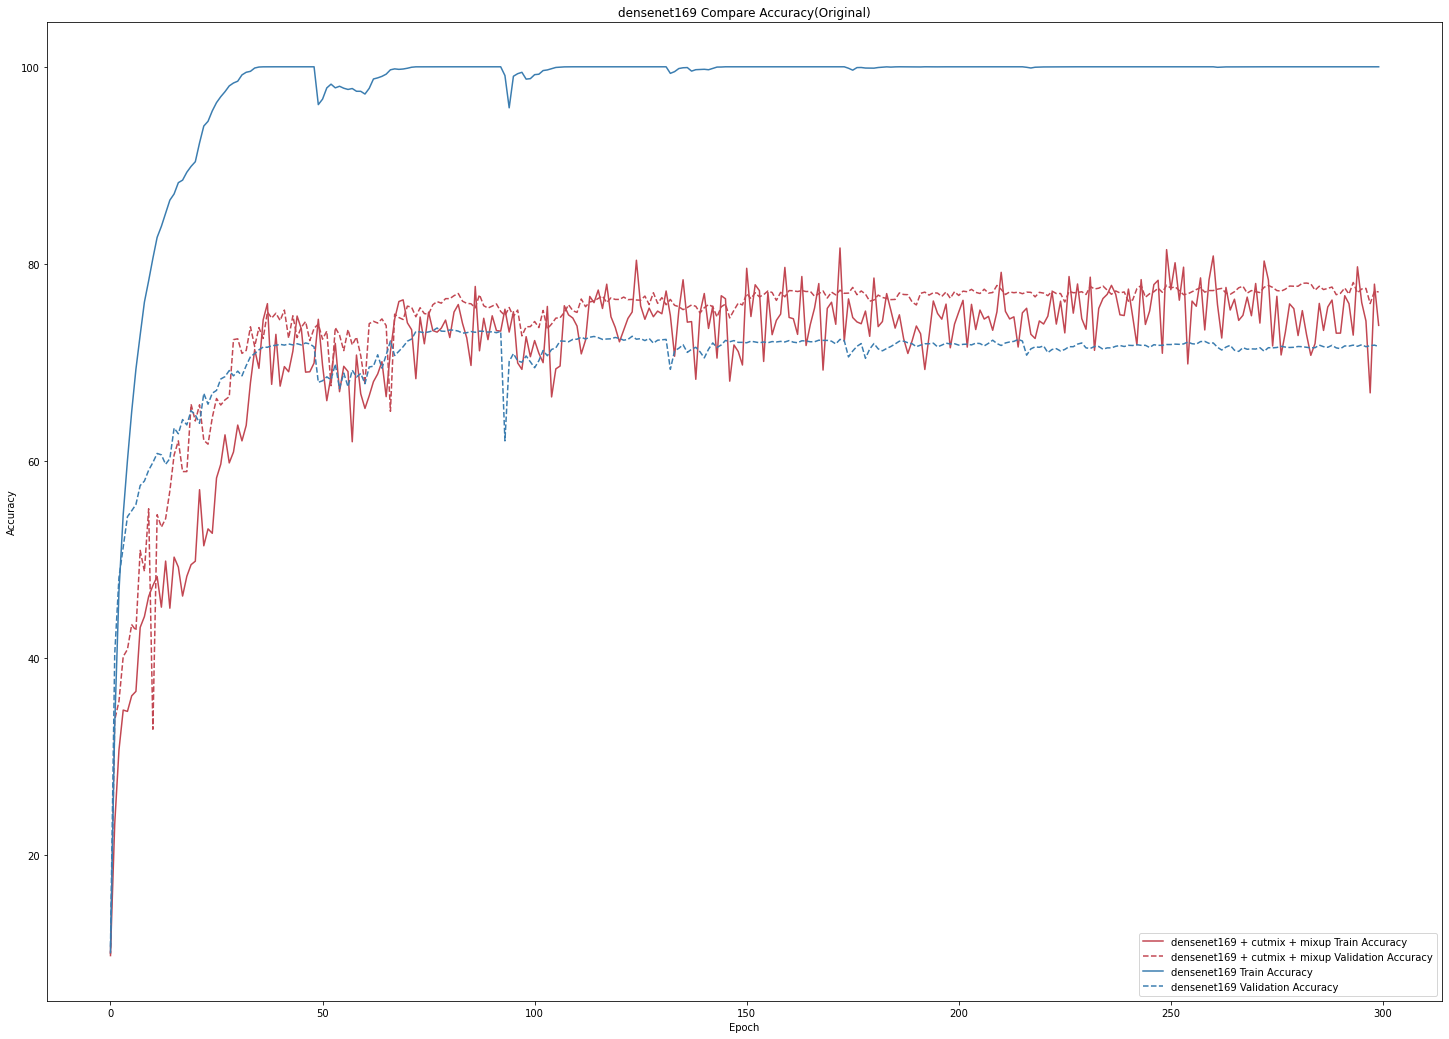

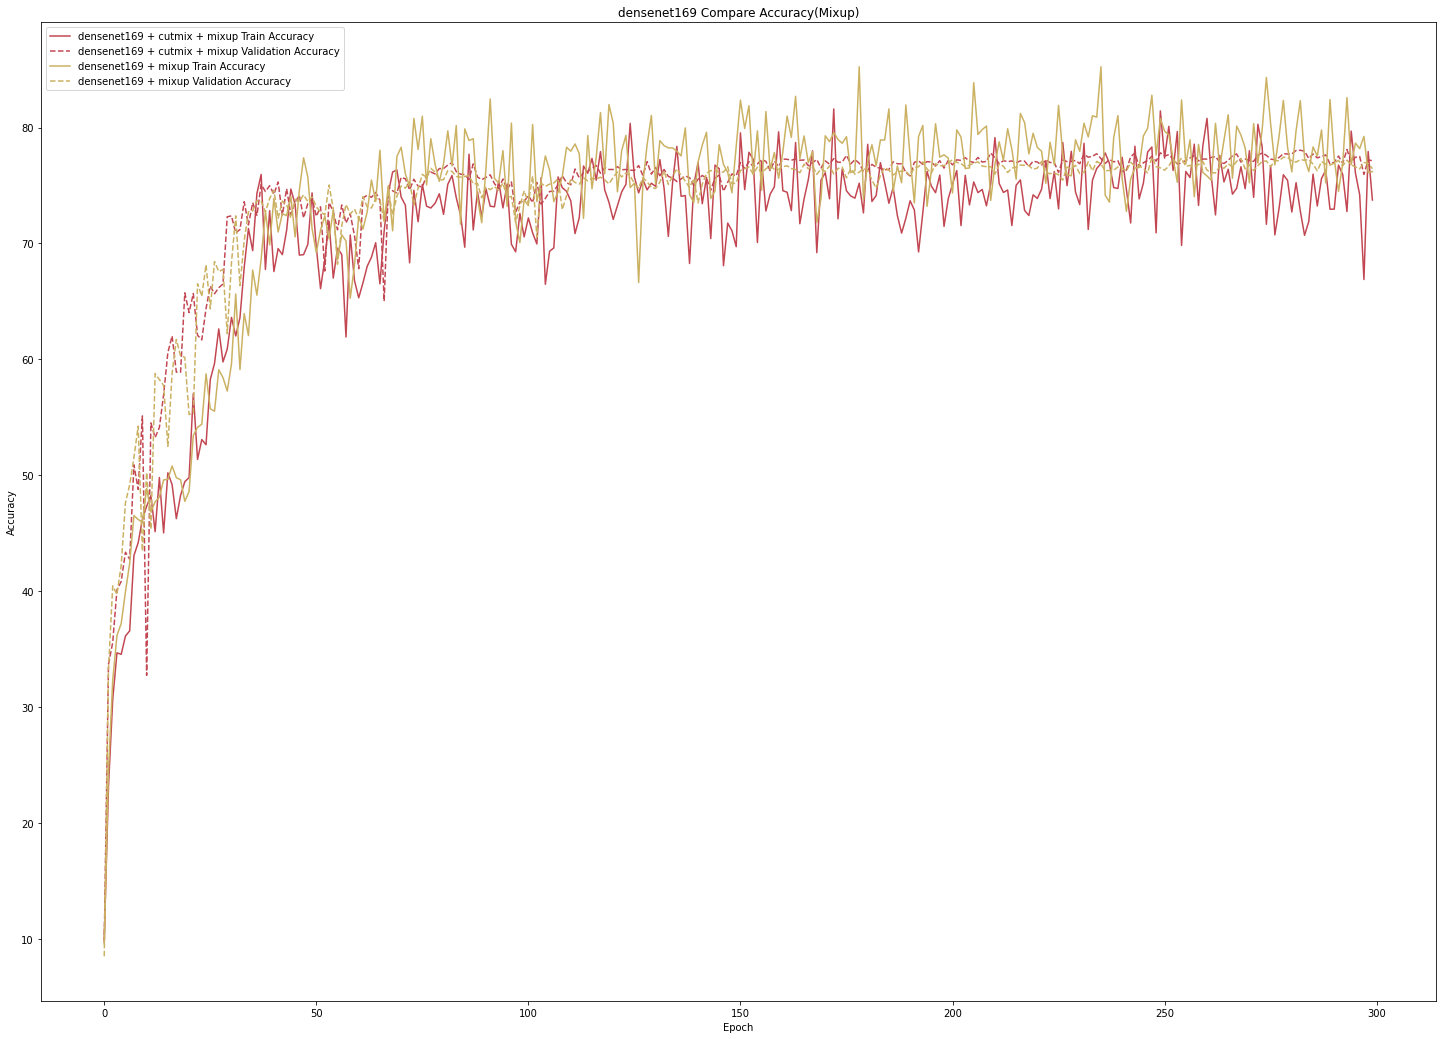

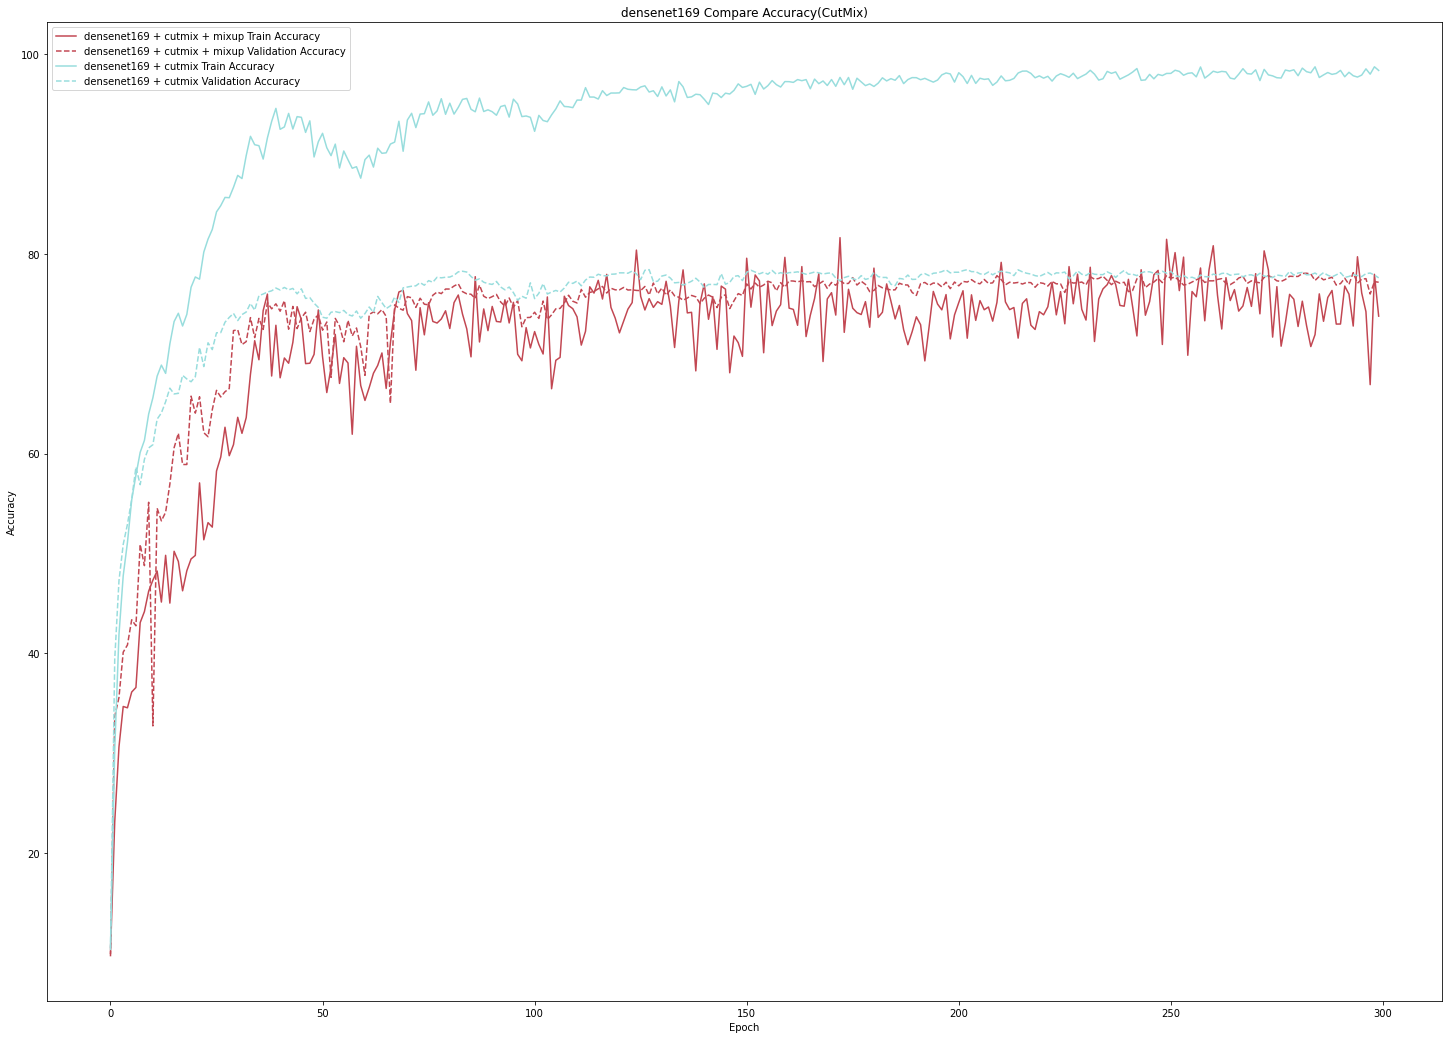

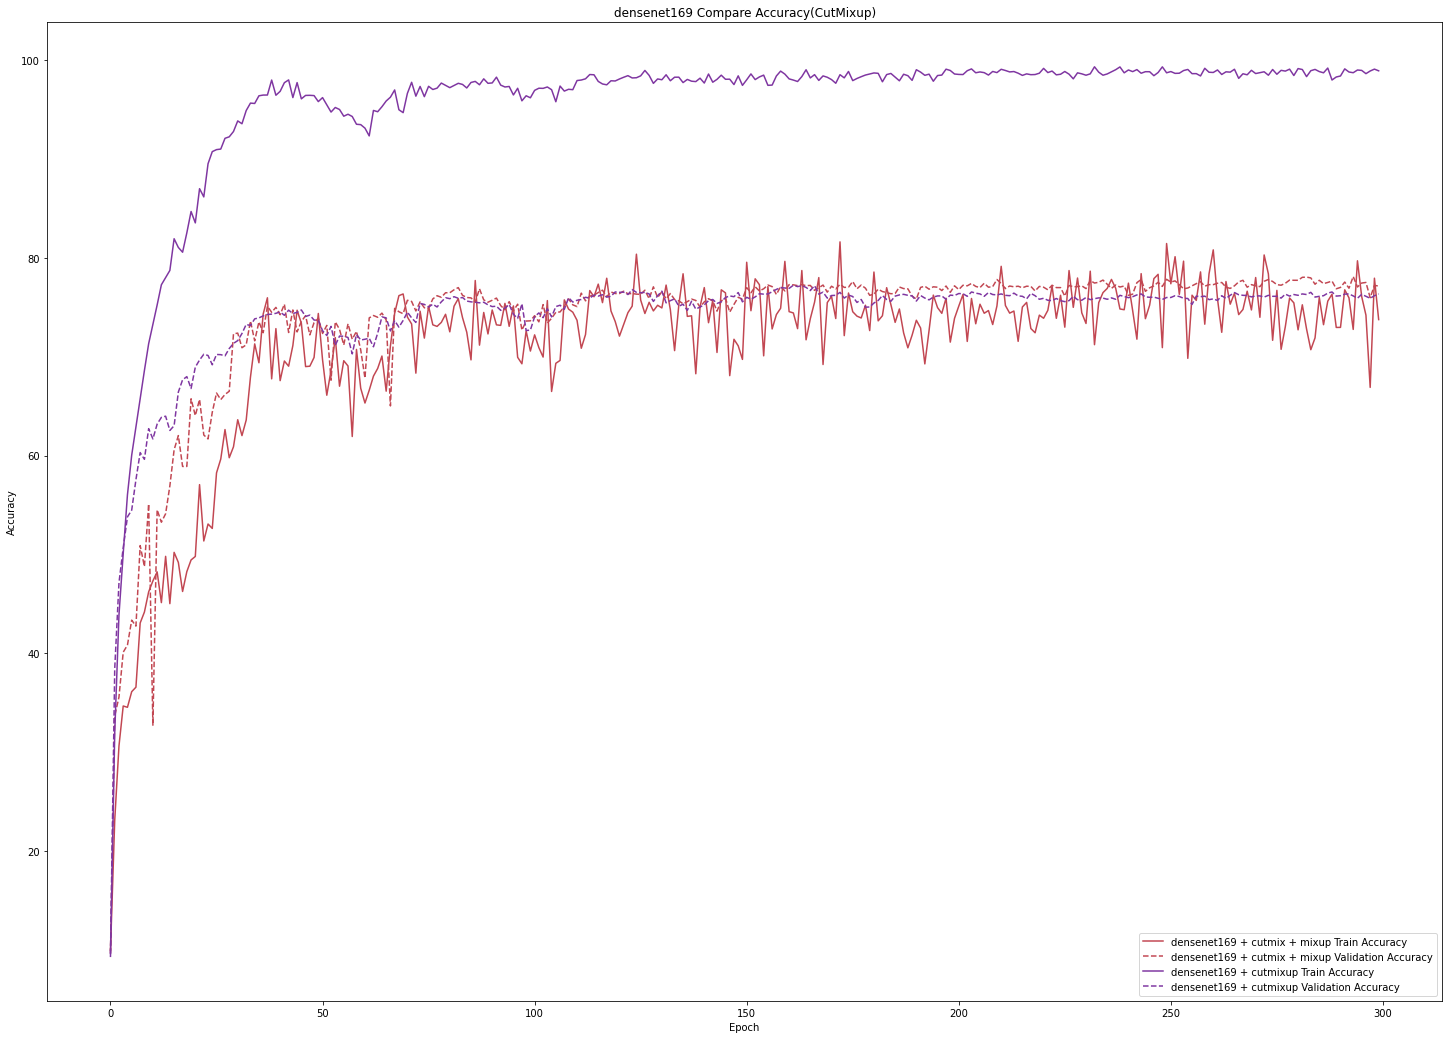

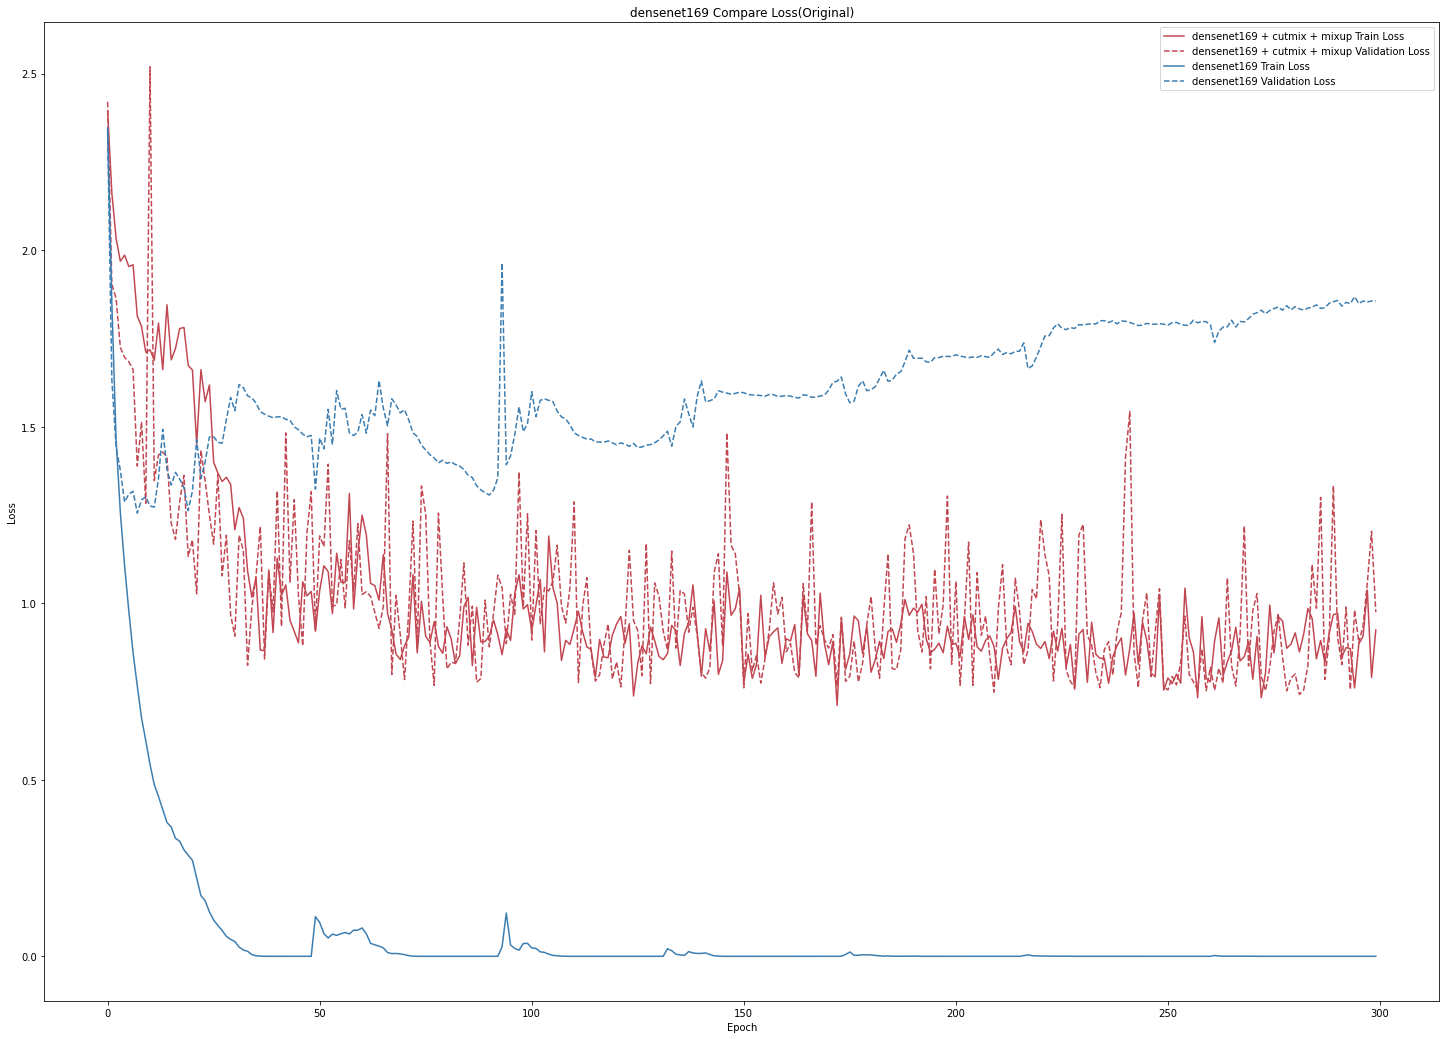

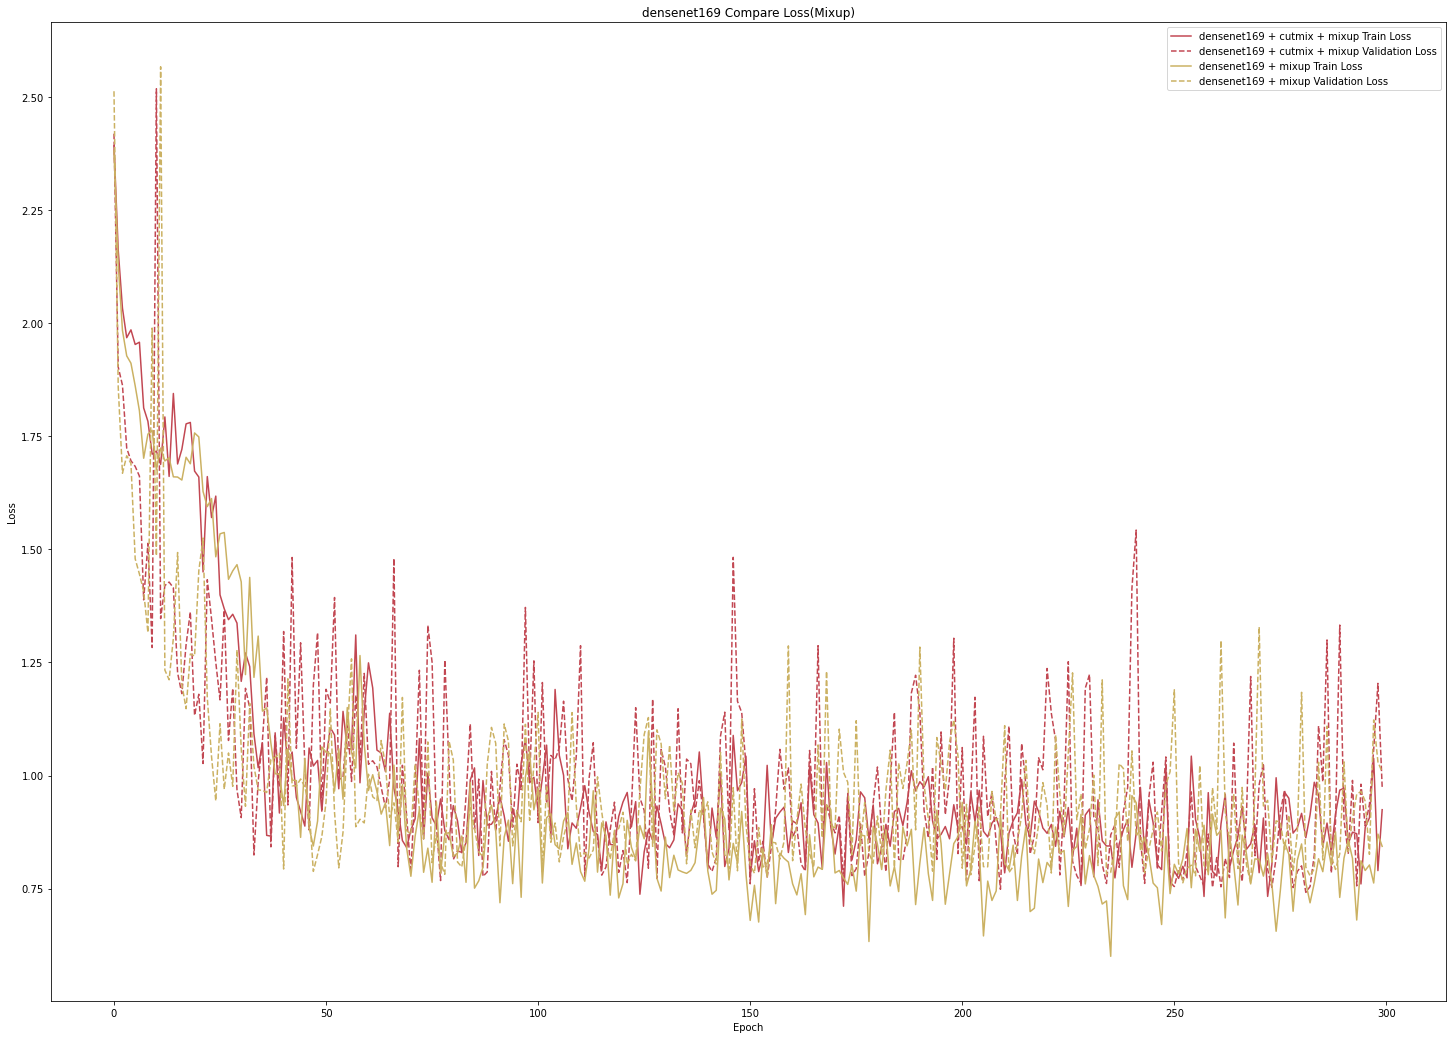

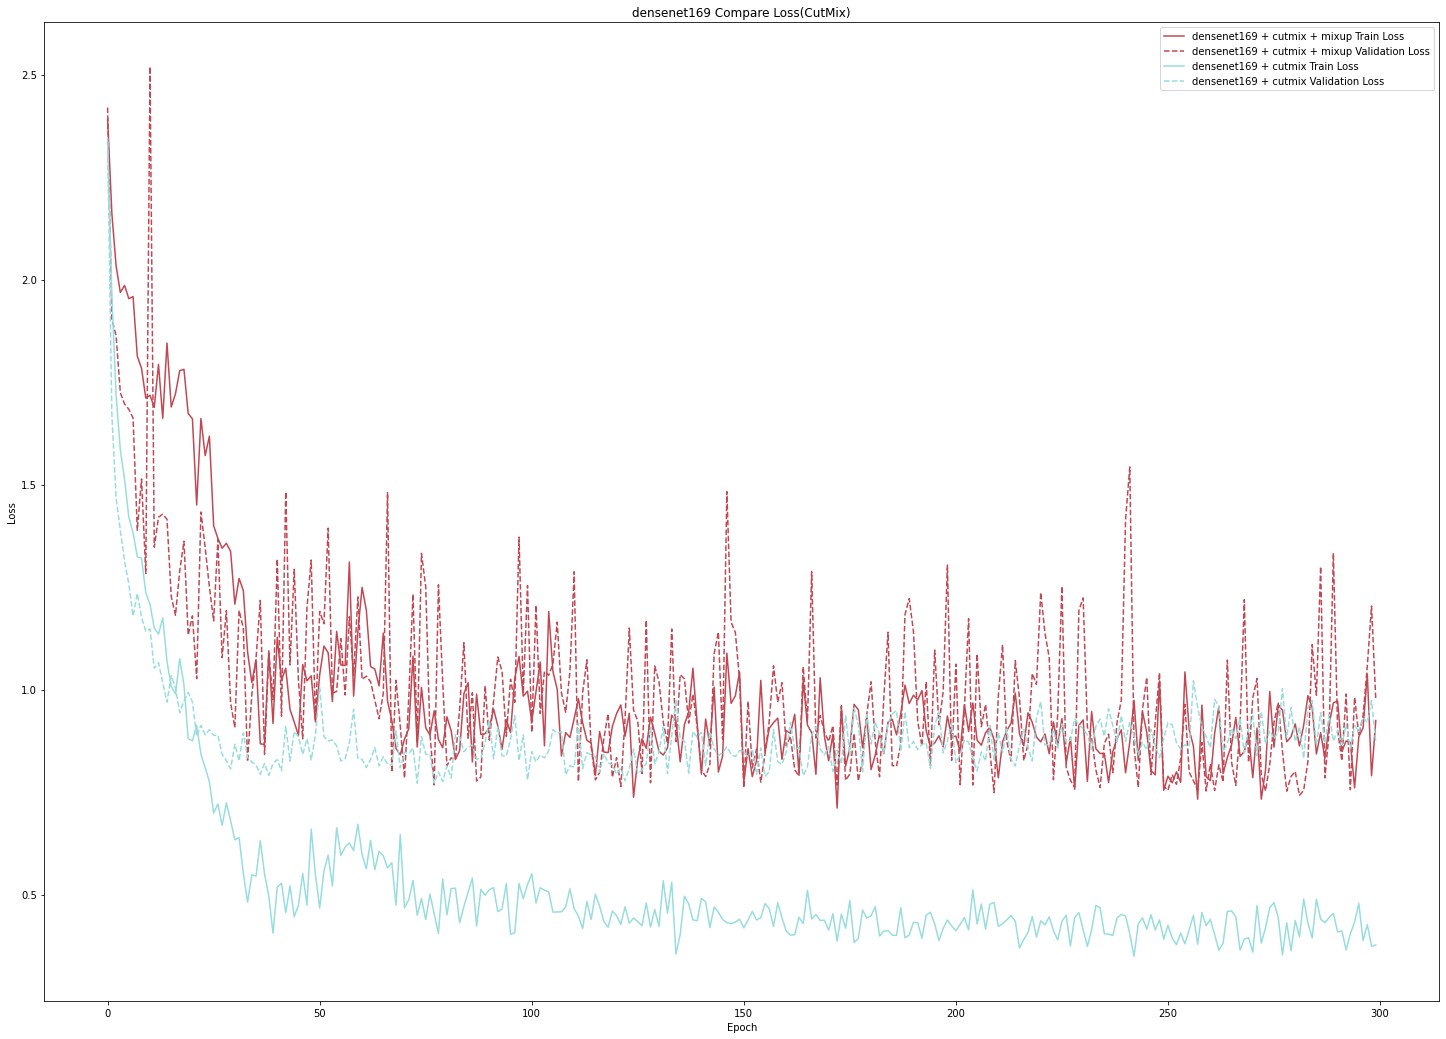

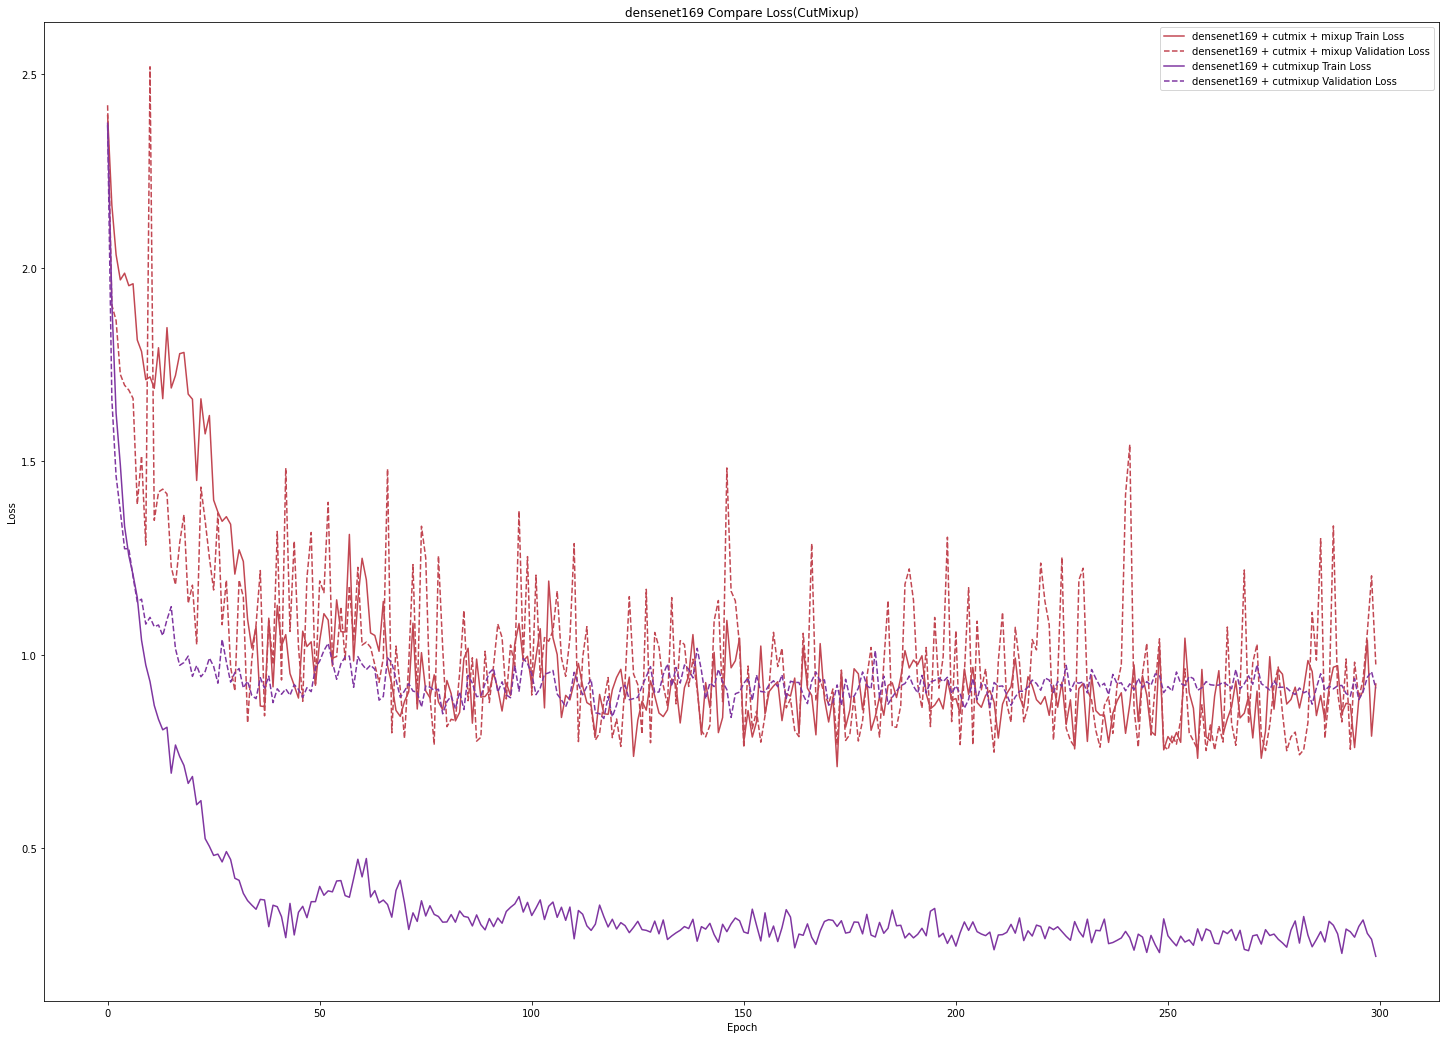

In [ ]:
print("--main--")
main_train_last_top1_acc,main_val_last_top1_acc,main_pytorch_total_params,main_train_loss_history,main_train_correct_history,main_validation_loss_history,main_validation_correct_history=main_main()
print("--ori--")
original_train_last_top1_acc,original_val_last_top1_acc,original_pytorch_total_params,original_train_loss_history,original_train_correct_history,original_validation_loss_history,original_validation_correct_history=ori_main()
print("--mixup--")
mixup_train_last_top1_acc,mixup_val_last_top1_acc,mixup_pytorch_total_params,mixup_train_loss_history,mixup_train_correct_history,mixup_validation_loss_history,mixup_validation_correct_history=mixup_main()
print("--cutmix--")
cutmix_train_last_top1_acc,cutmix_val_last_top1_acc,cutmix_pytorch_total_params,cutmix_train_loss_history,cutmix_train_correct_history,cutmix_validation_loss_history,cutmix_validation_correct_history=cutmix_main()
print("--cutmixup--")
cutmixup_train_last_top1_acc,cutmixup_val_last_top1_acc,cutmixup_pytorch_total_params,cutmixup_train_loss_history,cutmixup_train_correct_history,cutmixup_validation_loss_history,cutmixup_validation_correct_history=cutmixup_main()

print ("{:<30} {:<30} {:<30} {:<30}".format('Model','Train Last Top1 Accuracy','Validation Last Top1 Accuracy','Total Parameters'))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}',original_train_last_top1_acc,original_val_last_top1_acc,original_pytorch_total_params))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}+cutmix',cutmix_train_last_top1_acc,cutmix_val_last_top1_acc,cutmix_pytorch_total_params))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}+mixup',mixup_train_last_top1_acc,mixup_val_last_top1_acc,mixup_pytorch_total_params))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}+cutmixup',cutmixup_train_last_top1_acc,cutmixup_val_last_top1_acc,cutmixup_pytorch_total_params))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}+cutmix+mixup',main_train_last_top1_acc,main_val_last_top1_acc,main_pytorch_total_params))


X1 = np.arange(len(main_train_correct_history))
train_y1 = np.array(main_train_correct_history)
val_y1 = np.array(main_validation_correct_history)
train_ori_y1 = np.array(original_train_correct_history)
val_ori_y1 = np.array(original_validation_correct_history)
train_mixup_y1 = np.array(mixup_train_correct_history)
val_mixup_y1 = np.array(mixup_validation_correct_history)
train_cutmix_y1 = np.array(cutmix_train_correct_history)
val_cutmix_y1 = np.array(cutmix_validation_correct_history)
train_cutmixup_y1 = np.array(cutmixup_train_correct_history)
val_cutmixup_y1 = np.array(cutmixup_validation_correct_history)

X2 = np.arange(len(main_train_loss_history))
train_y2 = np.array(main_train_loss_history)
val_y2 = np.array(main_validation_loss_history)
train_ori_y2 = np.array(original_train_loss_history)
val_ori_y2 = np.array(original_validation_loss_history)
train_mixup_y2 = np.array(mixup_train_loss_history)
val_mixup_y2 = np.array(mixup_validation_loss_history)
train_cutmix_y2 = np.array(cutmix_train_loss_history)
val_cutmix_y2 = np.array(cutmix_validation_loss_history)
train_cutmixup_y2 = np.array(cutmixup_train_loss_history)
val_cutmixup_y2 = np.array(cutmixup_validation_loss_history)


plt.figure(1,figsize=IMGSIZE)
plt.plot(X1,train_y1,label=f"{MODELNAME} + cutmix + mixup Train Accuracy",color='#C24752', linestyle='-')
plt.plot(X1,val_y1,label=f"{MODELNAME} + cutmix + mixup Validation Accuracy",color='#C24752', linestyle='--')
plt.plot(X1,train_ori_y1,label=f"{MODELNAME} Train Accuracy",color='#3B7DB0', linestyle='-')
plt.plot(X1,val_ori_y1,label=f"{MODELNAME} Validation Accuracy",color='#3B7DB0', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{MODELNAME} Compare Accuracy(Original)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Accuracy_Original.png")

plt.figure(2,figsize=IMGSIZE)
plt.plot(X1,train_y1,label=f"{MODELNAME} + cutmix + mixup Train Accuracy",color='#C24752', linestyle='-')
plt.plot(X1,val_y1,label=f"{MODELNAME} + cutmix + mixup Validation Accuracy",color='#C24752', linestyle='--')
plt.plot(X1,train_mixup_y1,label=f"{MODELNAME} + mixup Train Accuracy",color='#CBB162', linestyle='-')
plt.plot(X1,val_mixup_y1,label=f"{MODELNAME} + mixup Validation Accuracy",color='#CBB162', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{MODELNAME} Compare Accuracy(Mixup)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Accuracy_Mixup.png")

plt.figure(3,figsize=IMGSIZE)
plt.plot(X1,train_y1,label=f"{MODELNAME} + cutmix + mixup Train Accuracy",color='#C24752', linestyle='-')
plt.plot(X1,val_y1,label=f"{MODELNAME} + cutmix + mixup Validation Accuracy",color='#C24752', linestyle='--')
plt.plot(X1,train_cutmix_y1,label=f"{MODELNAME} + cutmix Train Accuracy",color='#98DDDD', linestyle='-')
plt.plot(X1,val_cutmix_y1,label=f"{MODELNAME} + cutmix Validation Accuracy",color='#98DDDD', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{MODELNAME} Compare Accuracy(CutMix)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Accuracy_CutMix.png")

plt.figure(4,figsize=IMGSIZE)
plt.plot(X1,train_y1,label=f"{MODELNAME} + cutmix + mixup Train Accuracy",color='#C24752', linestyle='-')
plt.plot(X1,val_y1,label=f"{MODELNAME} + cutmix + mixup Validation Accuracy",color='#C24752', linestyle='--')
plt.plot(X1,train_cutmixup_y1,label=f"{MODELNAME} + cutmixup Train Accuracy",color='#7F36A1', linestyle='-')
plt.plot(X1,val_cutmixup_y1,label=f"{MODELNAME} + cutmixup Validation Accuracy",color='#7F36A1', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{MODELNAME} Compare Accuracy(CutMixup)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Accuracy_CutMixup.png")

plt.figure(5,figsize=IMGSIZE)
plt.plot(X2,train_y2,label=f"{MODELNAME} + cutmix + mixup Train Loss",color='#C24752', linestyle='-')
plt.plot(X2,val_y2,label=f"{MODELNAME} + cutmix + mixup Validation Loss",color='#C24752', linestyle='--')
plt.plot(X2,train_ori_y2,label=f"{MODELNAME} Train Loss",color='#3B7DB0', linestyle='-')
plt.plot(X2,val_ori_y2,label=f"{MODELNAME} Validation Loss",color='#3B7DB0', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{MODELNAME} Compare Loss(Original)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Loss_Original.png")

plt.figure(6,figsize=IMGSIZE)
plt.plot(X2,train_y2,label=f"{MODELNAME} + cutmix + mixup Train Loss",color='#C24752', linestyle='-')
plt.plot(X2,val_y2,label=f"{MODELNAME} + cutmix + mixup Validation Loss",color='#C24752', linestyle='--')
plt.plot(X2,train_mixup_y2,label=f"{MODELNAME} + mixup Train Loss",color='#CBB162', linestyle='-')
plt.plot(X2,val_mixup_y2,label=f"{MODELNAME} + mixup Validation Loss",color='#CBB162', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{MODELNAME} Compare Loss(Mixup)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Loss_Mixup.png")

plt.figure(7,figsize=IMGSIZE)
plt.plot(X2,train_y2,label=f"{MODELNAME} + cutmix + mixup Train Loss",color='#C24752', linestyle='-')
plt.plot(X2,val_y2,label=f"{MODELNAME} + cutmix + mixup Validation Loss",color='#C24752', linestyle='--')
plt.plot(X2,train_cutmix_y2,label=f"{MODELNAME} + cutmix Train Loss",color='#98DDDD', linestyle='-')
plt.plot(X2,val_cutmix_y2,label=f"{MODELNAME} + cutmix Validation Loss",color='#98DDDD', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{MODELNAME} Compare Loss(CutMix)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Loss_CutMix.png")

plt.figure(8,figsize=IMGSIZE)
plt.plot(X2,train_y2,label=f"{MODELNAME} + cutmix + mixup Train Loss",color='#C24752', linestyle='-')
plt.plot(X2,val_y2,label=f"{MODELNAME} + cutmix + mixup Validation Loss",color='#C24752', linestyle='--')
plt.plot(X2,train_cutmixup_y2,label=f"{MODELNAME} + cutmixup Train Loss",color='#7F36A1', linestyle='-')
plt.plot(X2,val_cutmixup_y2,label=f"{MODELNAME} + cutmixup Validation Loss",color='#7F36A1', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{MODELNAME} Compare Loss(CutMixup)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Loss_CutMixup.png")
    

## Test

In [ ]:
# -*- coding: utf-8 -*-

# import argparse
from random import sample
import pandas as pd


def eval():
    model1 = densenet169(num_classes=NUMCLASSES)
    model2 = densenet169(num_classes=NUMCLASSES)
    model3 = densenet169(num_classes=NUMCLASSES)
    model4 = densenet169(num_classes=NUMCLASSES)
    model5 = densenet169(num_classes=NUMCLASSES)
    model1 = model1.cuda() if IsGPU else model1
    model2 = model2.cuda() if IsGPU else model2
    model3 = model3.cuda() if IsGPU else model3
    model4 = model4.cuda() if IsGPU else model4
    model5 = model5.cuda() if IsGPU else model5
    model1.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}.pth'))
    model2.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}_cutmix.pth'))
    model3.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}_mixup.pth'))
    model4.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}_original.pth'))
    model5.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}_cutmixup.pth'))
    
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()
    model5.eval()

    total = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0
    correct4 = 0
    correct5 = 0
    print('Evaluate...')
    with torch.no_grad():
        for i, (input, target) in enumerate(testloader):
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target
            output1 = model1(input)
            output2 = model2(input)
            output3 = model3(input)
            output4 = model4(input)
            output5 = model5(input)
            _, predictions1 = torch.max(output1, 1)
            _, predictions2 = torch.max(output2, 1)
            _, predictions3 = torch.max(output3, 1)
            _, predictions4 = torch.max(output4, 1)
            _, predictions5 = torch.max(output5, 1)
            total += target.size(0)
            correct1 += (predictions1 == target).sum().item()
            correct2 += (predictions2 == target).sum().item()
            correct3 += (predictions3 == target).sum().item()
            correct4 += (predictions4 == target).sum().item()
            correct5 += (predictions5 == target).sum().item()
        

    print(f'Accuracy of cutmix and mixup {MODELNAME} on the 10000 test images: {100 * correct1 / total:.2f} %')
    print(f'Accuracy of cutmix {MODELNAME} on the 10000 test images: {100 * correct2 / total:.2f} %')
    print(f'Accuracy of mixup {MODELNAME} on the 10000 test images: {100 * correct3 / total:.2f} %')
    print(f'Accuracy of original {MODELNAME} on the 10000 test images: {100 * correct4 / total:.2f} %')
    print(f'Accuracy of cutmixup {MODELNAME} on the 10000 test images: {100 * correct5 / total:.2f} %')


if __name__ == "__main__":
    eval()

Evaluate...
Accuracy of cutmix and mixup densenet169 on the 10000 test images: 77.95 %
Accuracy of cutmix densenet169 on the 10000 test images: 77.72 %
Accuracy of mixup densenet169 on the 10000 test images: 77.07 %
Accuracy of original densenet169 on the 10000 test images: 71.45 %
Accuracy of cutmixup densenet169 on the 10000 test images: 76.87 %


# resnet34

## MODEL

In [ ]:
def resnet34():
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3])
    return model

## MODELNAME

In [ ]:
MODELNAME='resnet34'

## Train & Validation

In [ ]:
### main
def main_main():
    model = resnet34()

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = main_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = main_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    
    


def main_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if i % np.random.randint(1,6) == 0:
            temp_X_1 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            temp_X_2 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            lam1 = LAMBDA1
            lam2 = LAMBDA2
            lam3 = LAMBDA3
            rand_index = torch.randperm(input.size()[0]).cuda() if IsGPU else torch.randperm(input.size()[0])
            shuffled_y = target[rand_index]

            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam1)
            input[:,:,bbx1:bbx2, bby1:bby2] = input[shuffled_y,:,bbx1:bbx2, bby1:bby2]
            temp_X_2[:,:,:,:]=temp_X_2[shuffled_y,:,:,:]
            lam1 = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
            mixed_1 = lam2 * input + (1 - lam2) * temp_X_1
            mixed_1 = mixed_1.cuda() if IsGPU else mixed_1
            mixed_2 = lam3 * mixed_1 + (1 - lam3) * temp_X_2
            mixed_2 = mixed_2.cuda() if IsGPU else mixed_2

            # compute output
            output = model(mixed_2)
            loss = mixup_criterion(criterion,output,target,shuffled_y,lam1*lam2*lam3+(1-lam2)*lam3)

        else:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def main_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg


In [ ]:
### main
def cutmixup_main():
    model = resnet34()

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = cutmixup_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = cutmixup_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}_cutmixup.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    
    


def cutmixup_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if i % np.random.randint(1,6) == 0:
            temp_X_1 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            temp_X_2 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            lam1 = LAMBDA1
            lam2 = LAMBDA2
            rand_index = torch.randperm(input.size()[0]).cuda() if IsGPU else torch.randperm(input.size()[0])
            shuffled_y = target[rand_index]
            temp_X_2[:,:,:,:]=temp_X_2[shuffled_y,:,:,:]
            mixed_1 = lam2 * input + (1 - lam2) * temp_X_2
            mixed_1 = mixed_1.cuda() if IsGPU else mixed_1


            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam1)
            input[:,:,bbx1:bbx2, bby1:bby2] = mixed_1[:,:,bbx1:bbx2, bby1:bby2]
            lam1 = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))

            # compute output
            output = model(input)
            loss = mixup_criterion(criterion,output,target,shuffled_y,1-lam2+lam1*lam2)

        else:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def cutmixup_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg


In [ ]:
# -*- coding: utf-8 -*-
###original
def ori_main():
    model = resnet34()

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = ori_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = ori_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}_original.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    
    


def ori_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        input = input.cuda() if IsGPU else input
        target = target.cuda() if IsGPU else target

        output = model(input)
        loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def ori_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg


In [ ]:
def mixup_main():
    model = resnet34()

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = mixup_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = mixup_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}_mixup.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")
    

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    


def mixup_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if i % np.random.randint(1,6) == 0:
            temp_X_1 = input.clone().detach().cuda() if IsGPU else input.clone().detach()
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            lam2 = LAMBDA2
            rand_index = torch.randperm(input.size()[0]).cuda() if IsGPU else torch.randperm(input.size()[0])
            shuffled_y = target[rand_index]

            temp_X_1[:,:,:,:]=temp_X_1[shuffled_y,:,:,:]
            mixed_1 = lam2 * input + (1 - lam2) * temp_X_1
            mixed_1 = mixed_1.cuda() if IsGPU else mixed_1

            # compute output
            output = model(mixed_1)
            loss = mixup_criterion(criterion,output,target,shuffled_y,lam2)

        else:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def mixup_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg



In [ ]:
def cutmix_main():
    model = resnet34()

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNINGRATE,
                                weight_decay=WEIGHTDECAY)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=MINLR, 
                                            step_size_up=STEPSIZEUP, max_lr=LEARNINGRATE, 
                                            gamma=GAMMA_CYCLE, mode='triangular2',cycle_momentum=False)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda() if IsGPU else model
    criterion = criterion.cuda() if IsGPU else criterion

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    train_last_top1_acc = 0
    val_last_top1_acc = 0
    train_loss_history = []
    train_correct_history = []
    validation_loss_history = []
    validation_correct_history = []

    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))
        
        # train for one epoch
        start_time = time.time()
        train_last_top1_acc, train_loss = cutmix_training(trainloader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))
        
        # validate for one epoch
        start_time = time.time()
        val_last_top1_acc, val_loss = cutmix_validating(validationloader,epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to validate this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        train_loss_history.append(train_loss)
        train_correct_history.append(train_last_top1_acc)
        validation_loss_history.append(val_loss)
        validation_correct_history.append(val_last_top1_acc)

        # Save model each epoch
        torch.save(model.state_dict(), f'{MODELPATH}/model_weight_{MODELNAME}_cutmix.pth')

    print(f"Train Last Top-1 Accuracy: {train_last_top1_acc}")
    print(f"Validation Last Top-1 Accuracy: {val_last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")

    return train_last_top1_acc,val_last_top1_acc,pytorch_total_params,train_loss_history,train_correct_history,validation_loss_history,validation_correct_history
    
    


def cutmix_training(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    torch.cuda.empty_cache()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if i % np.random.randint(1,6) == 0:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            lam1 = LAMBDA1
            rand_index = torch.randperm(input.size()[0]).cuda() if IsGPU else torch.randperm(input.size()[0])
            shuffled_y = target[rand_index]

            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam1)
            input[:,:,bbx1:bbx2, bby1:bby2] = input[shuffled_y,:,bbx1:bbx2, bby1:bby2]
            lam1 = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))

            # compute output
            output = model(input)
            loss = mixup_criterion(criterion,output,target,shuffled_y,lam1)

        else:
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)


        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg, losses.avg

def cutmix_validating(val_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target

            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss, accuracy 
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0].item(), input.size(0))
            top5.update(acc5[0].item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINTFREQ == 0:
                progress.print(i)

        print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))
        return top1.avg, losses.avg


## Run

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

Epoch: [22][ 0/20]	Time  0.262 ( 0.262)	Data  0.239 ( 0.239)	Loss 1.2640e+00 (1.2640e+00)	Acc@1  60.55 ( 60.55)	Acc@5  94.92 ( 94.92)
=> Acc@1 62.460 Acc@5 95.400
==> 0.82 seconds to validate this epoch


----- epoch: 23, lr: 0.000850015 -----
Epoch: [23][  0/176]	Time  0.334 ( 0.334)	Data  0.262 ( 0.262)	Loss 6.0638e-01 (6.0638e-01)	Acc@1  89.06 ( 89.06)	Acc@5 100.00 (100.00)
Epoch: [23][ 20/176]	Time  0.046 ( 0.060)	Data  0.002 ( 0.014)	Loss 6.1658e-01 (5.0439e-01)	Acc@1  88.67 ( 88.30)	Acc@5  99.22 ( 99.74)
Epoch: [23][ 40/176]	Time  0.048 ( 0.053)	Data  0.002 ( 0.008)	Loss 7.1321e-01 (4.9664e-01)	Acc@1  86.72 ( 88.52)	Acc@5 100.00 ( 99.76)
Epoch: [23][ 60/176]	Time  0.045 ( 0.051)	Data  0.002 ( 0.006)	Loss 7.8598e-01 (4.9747e-01)	Acc@1  85.94 ( 88.26)	Acc@5  99.22 ( 99.73)
Epoch: [23][ 80/176]	Time  0.048 ( 0.050)	Data  0.002 ( 0.005)	Loss 7.7914e-01 (5.1486e-01)	Acc@1  84.38 ( 87.87)	Acc@5  99.22 ( 99.71)
Epoch: [23][100/176]	Time  0.057 ( 0.04

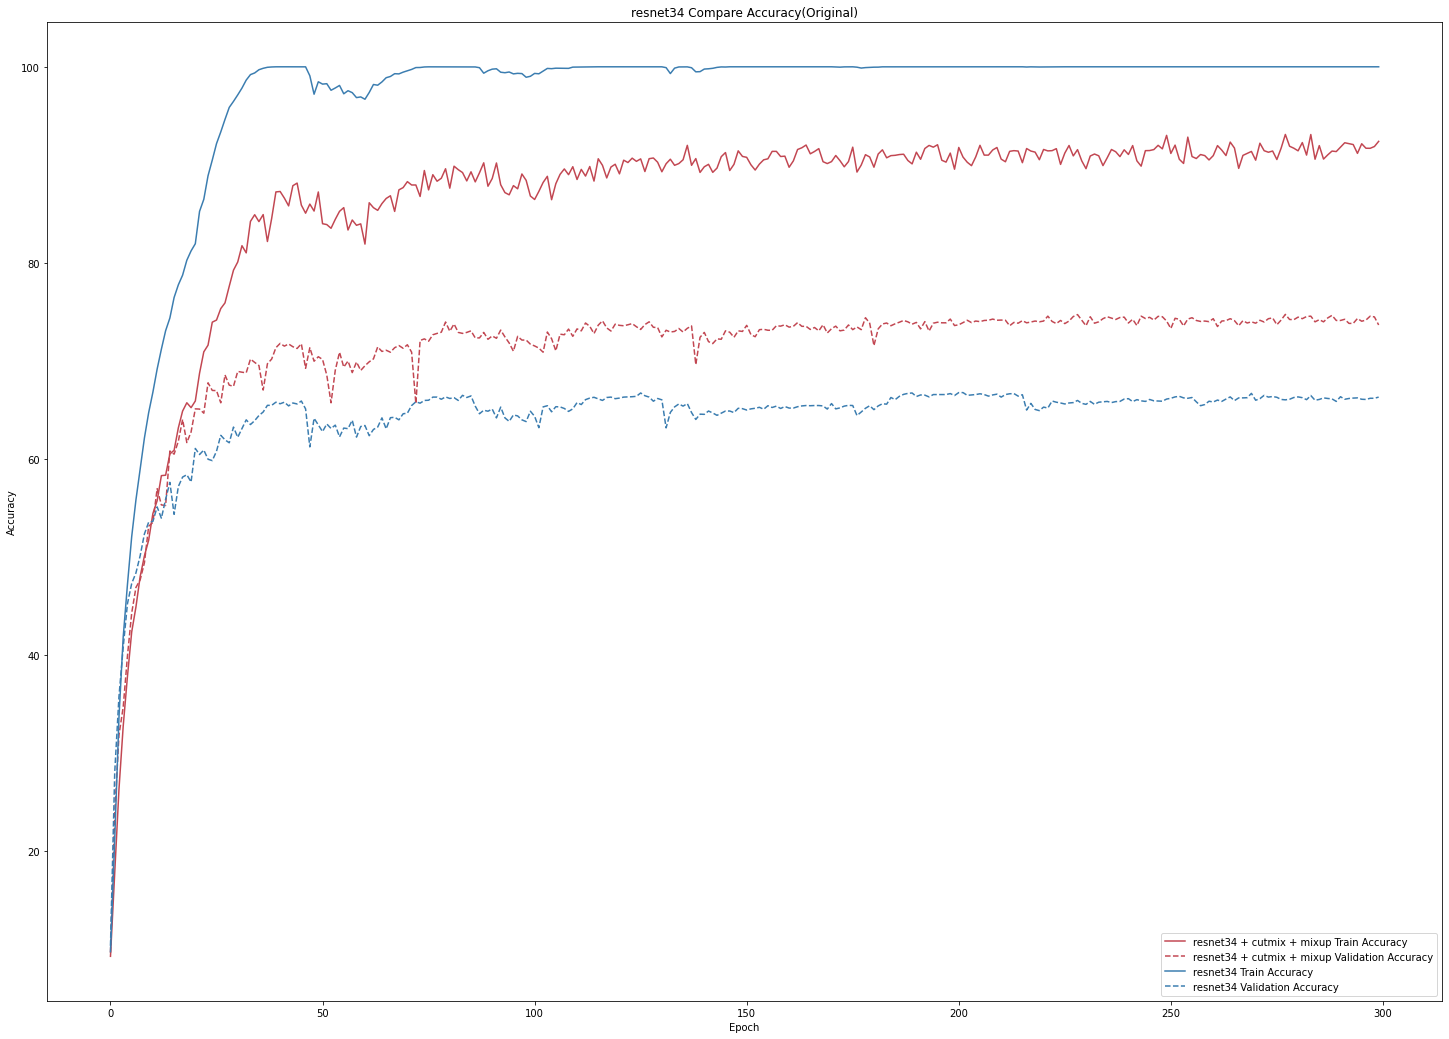

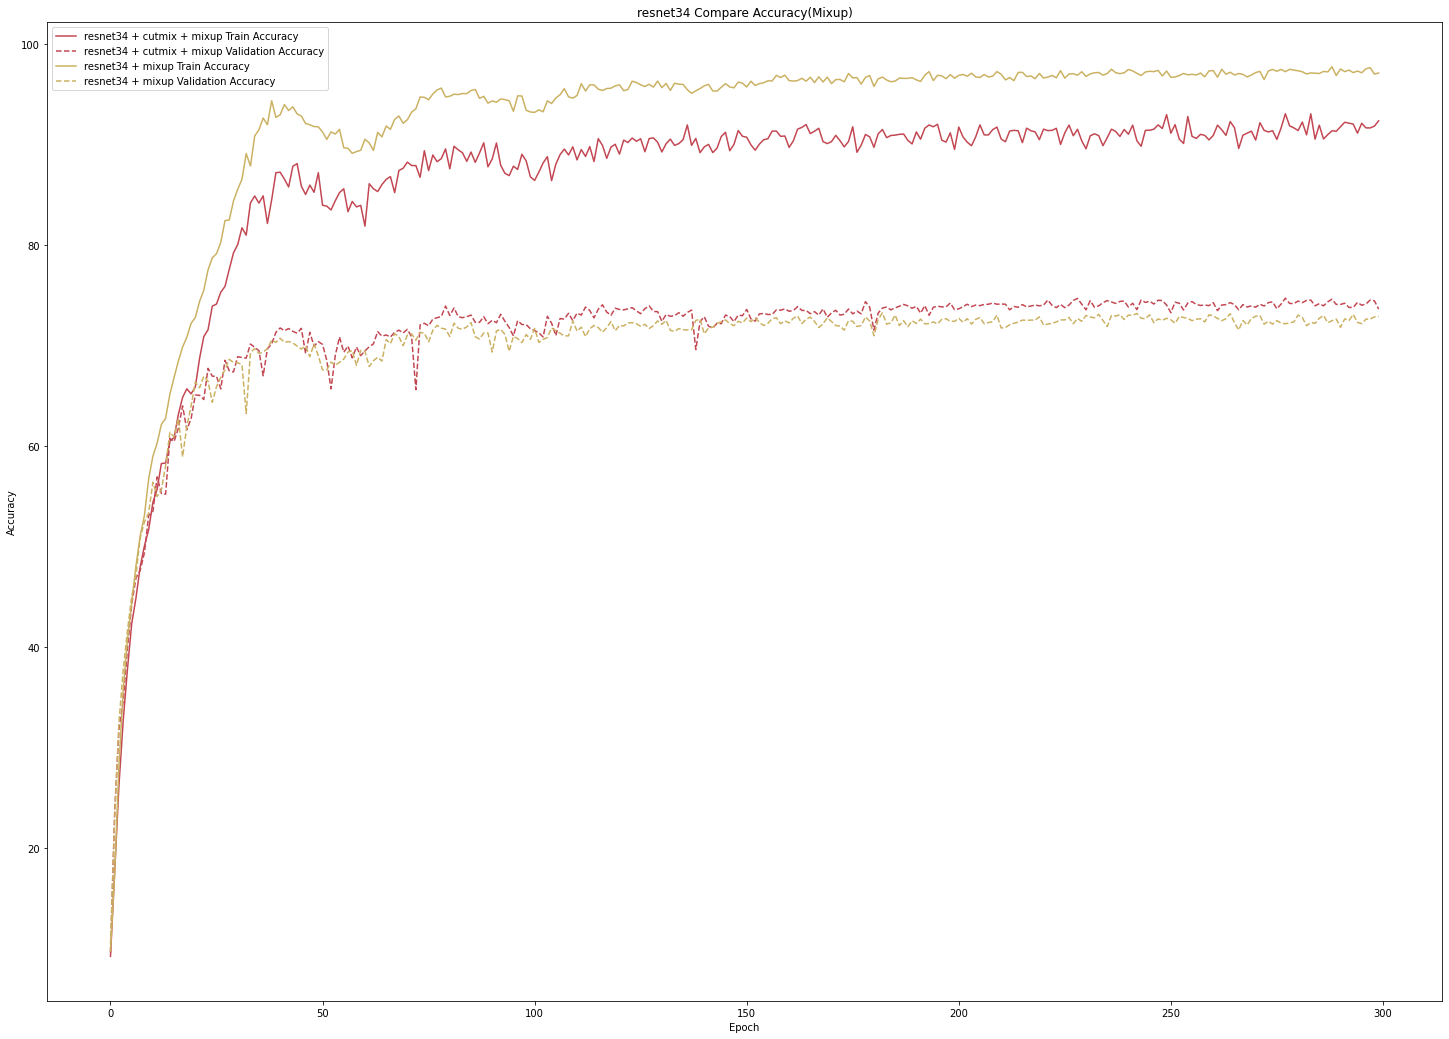

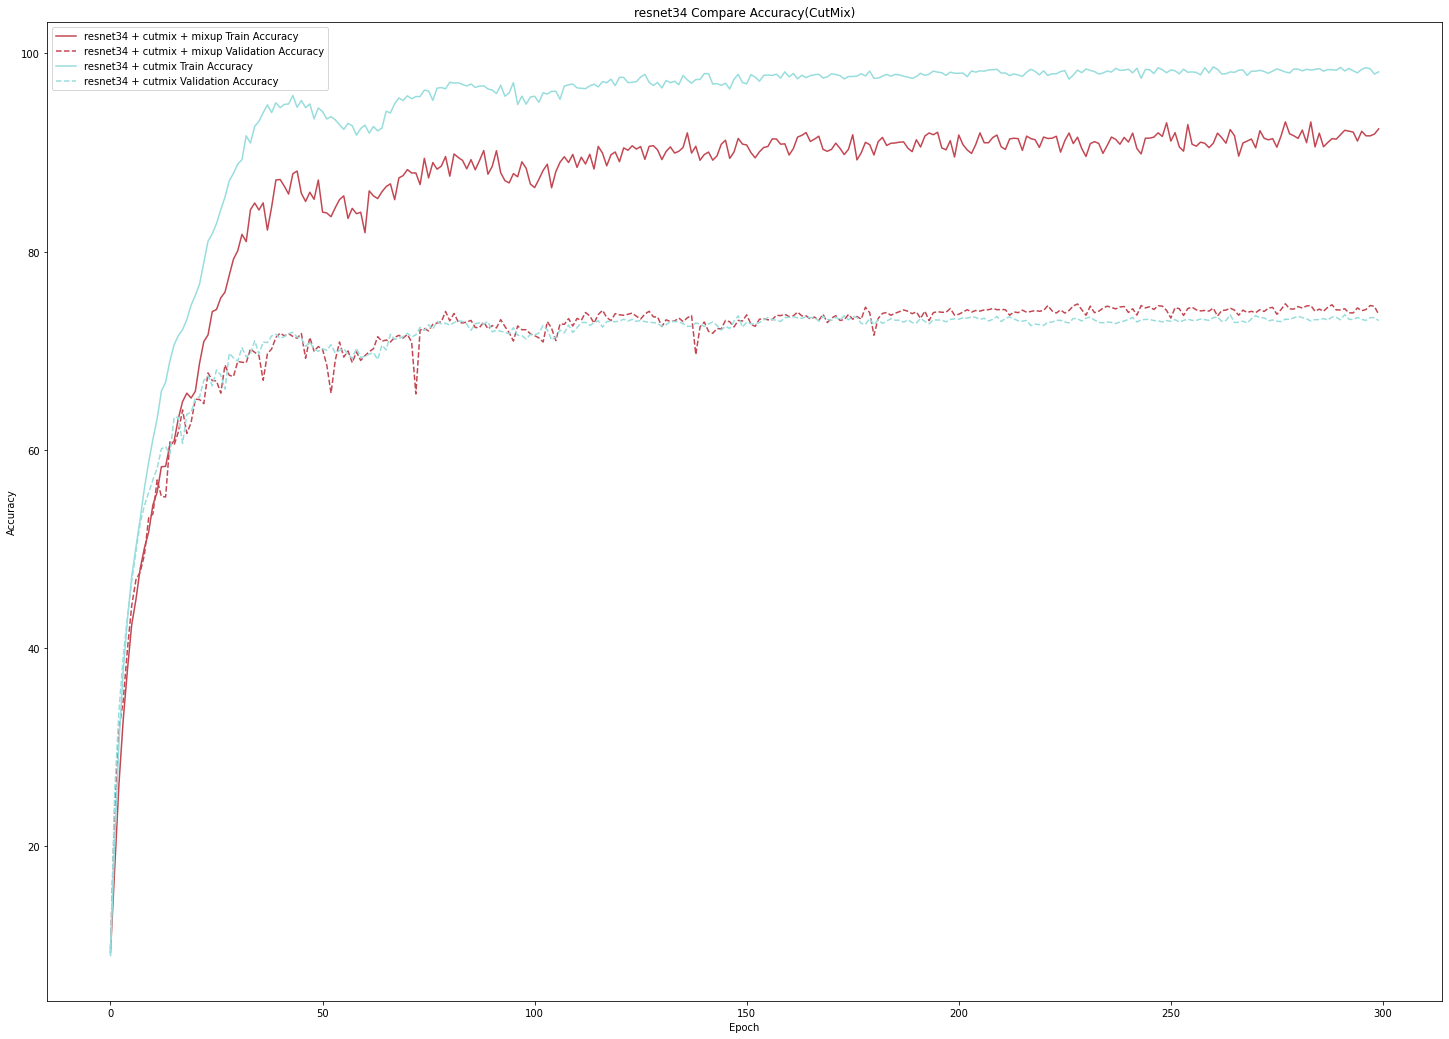

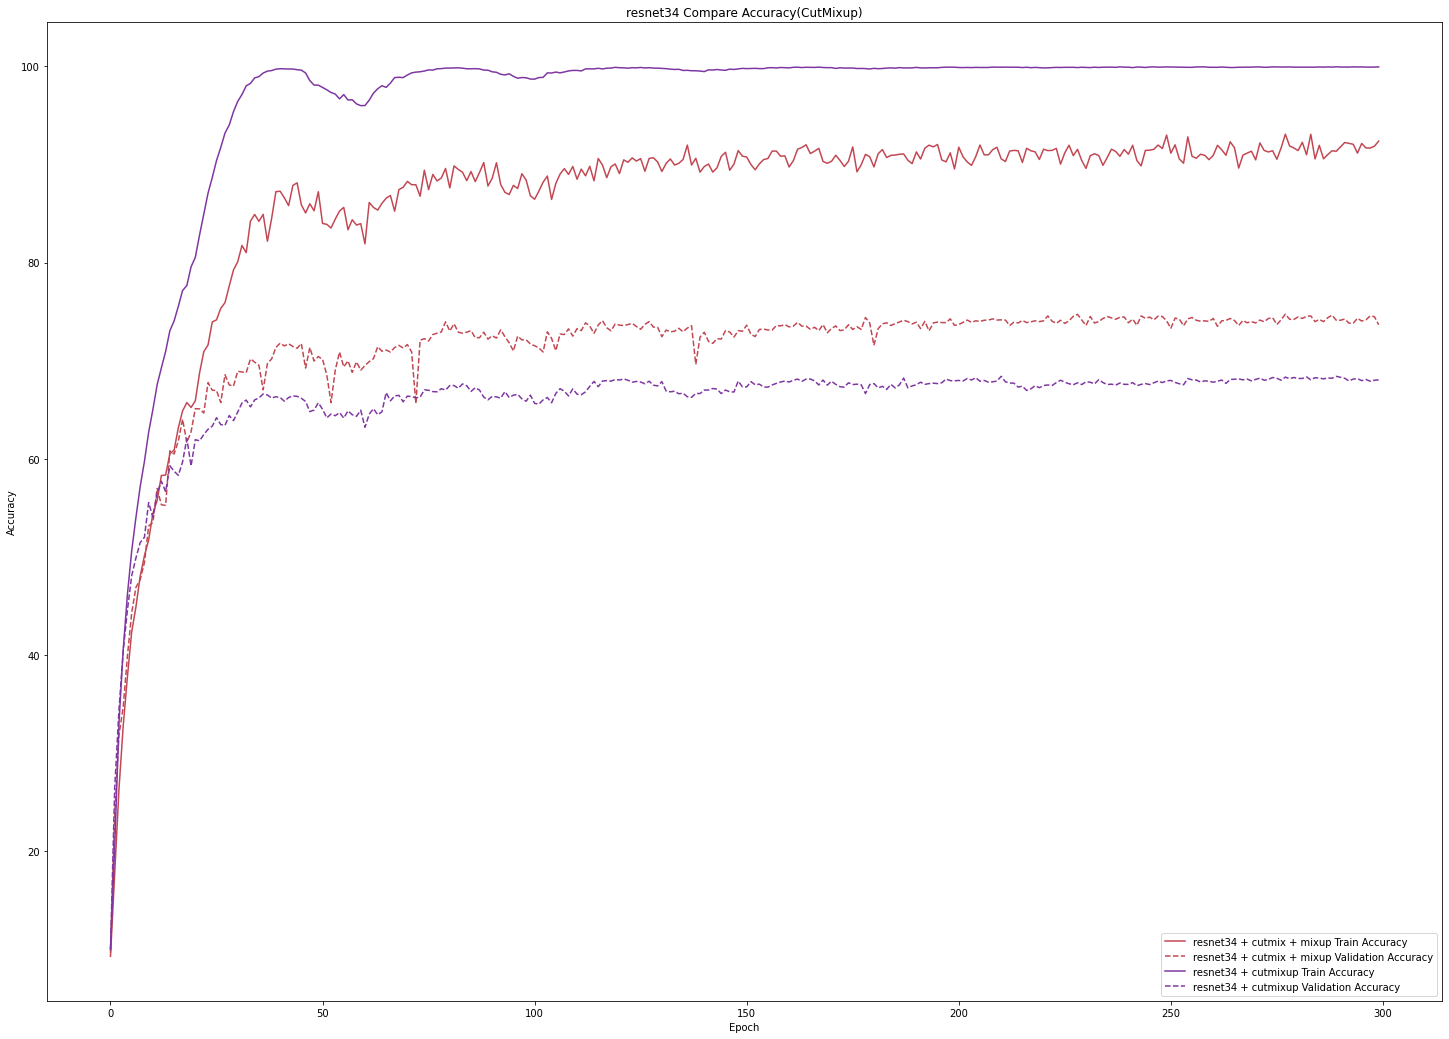

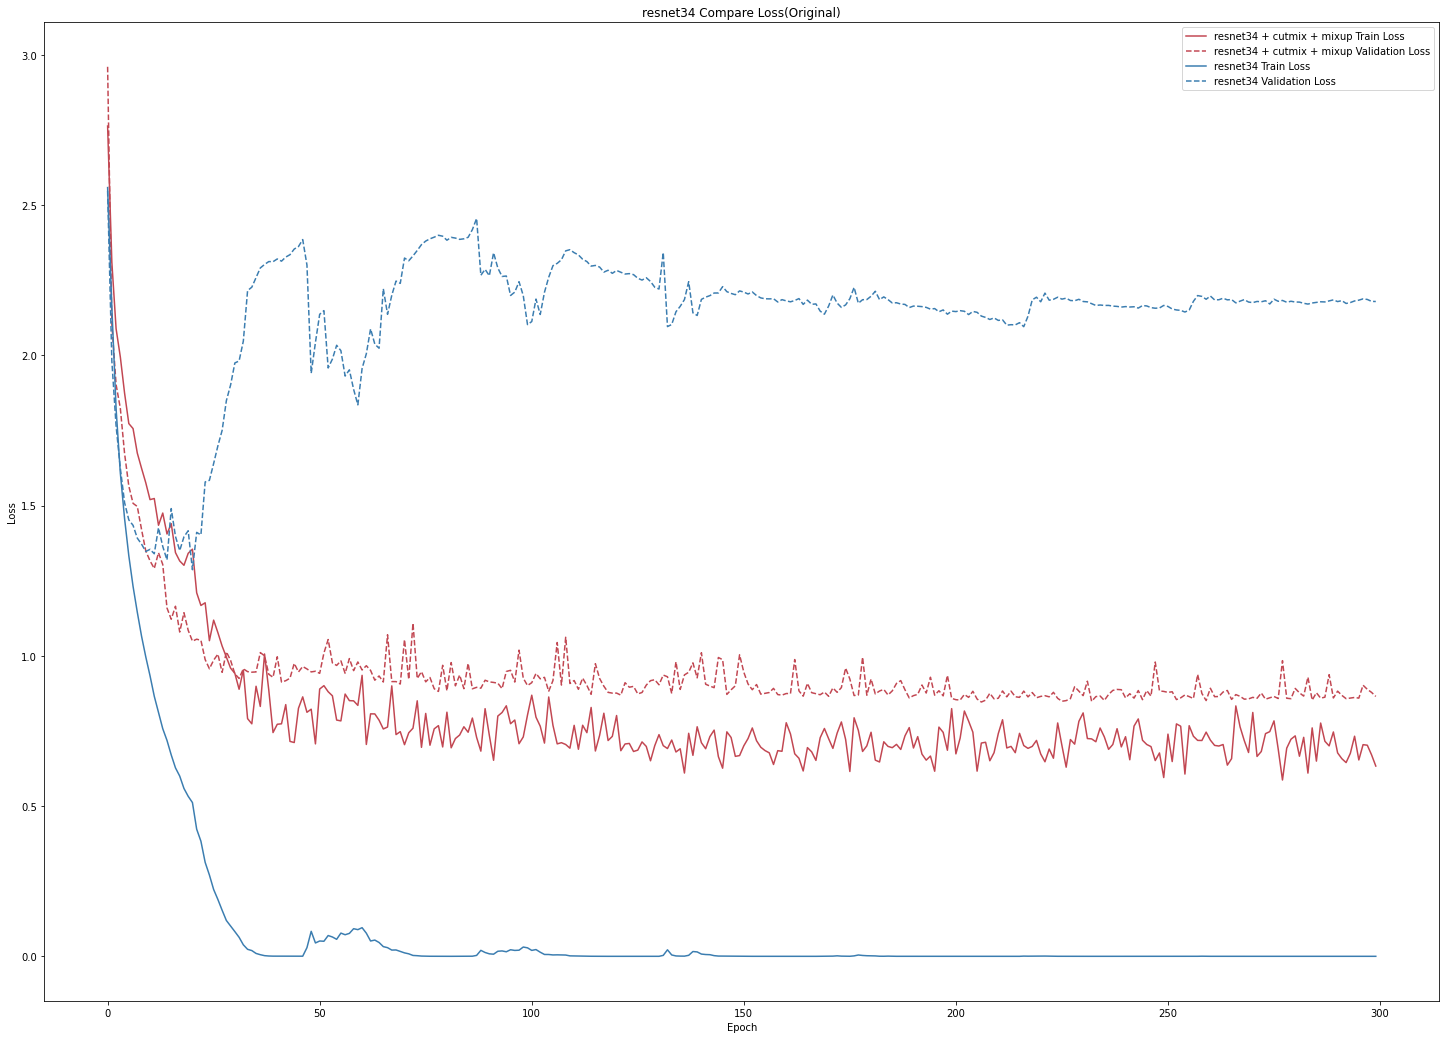

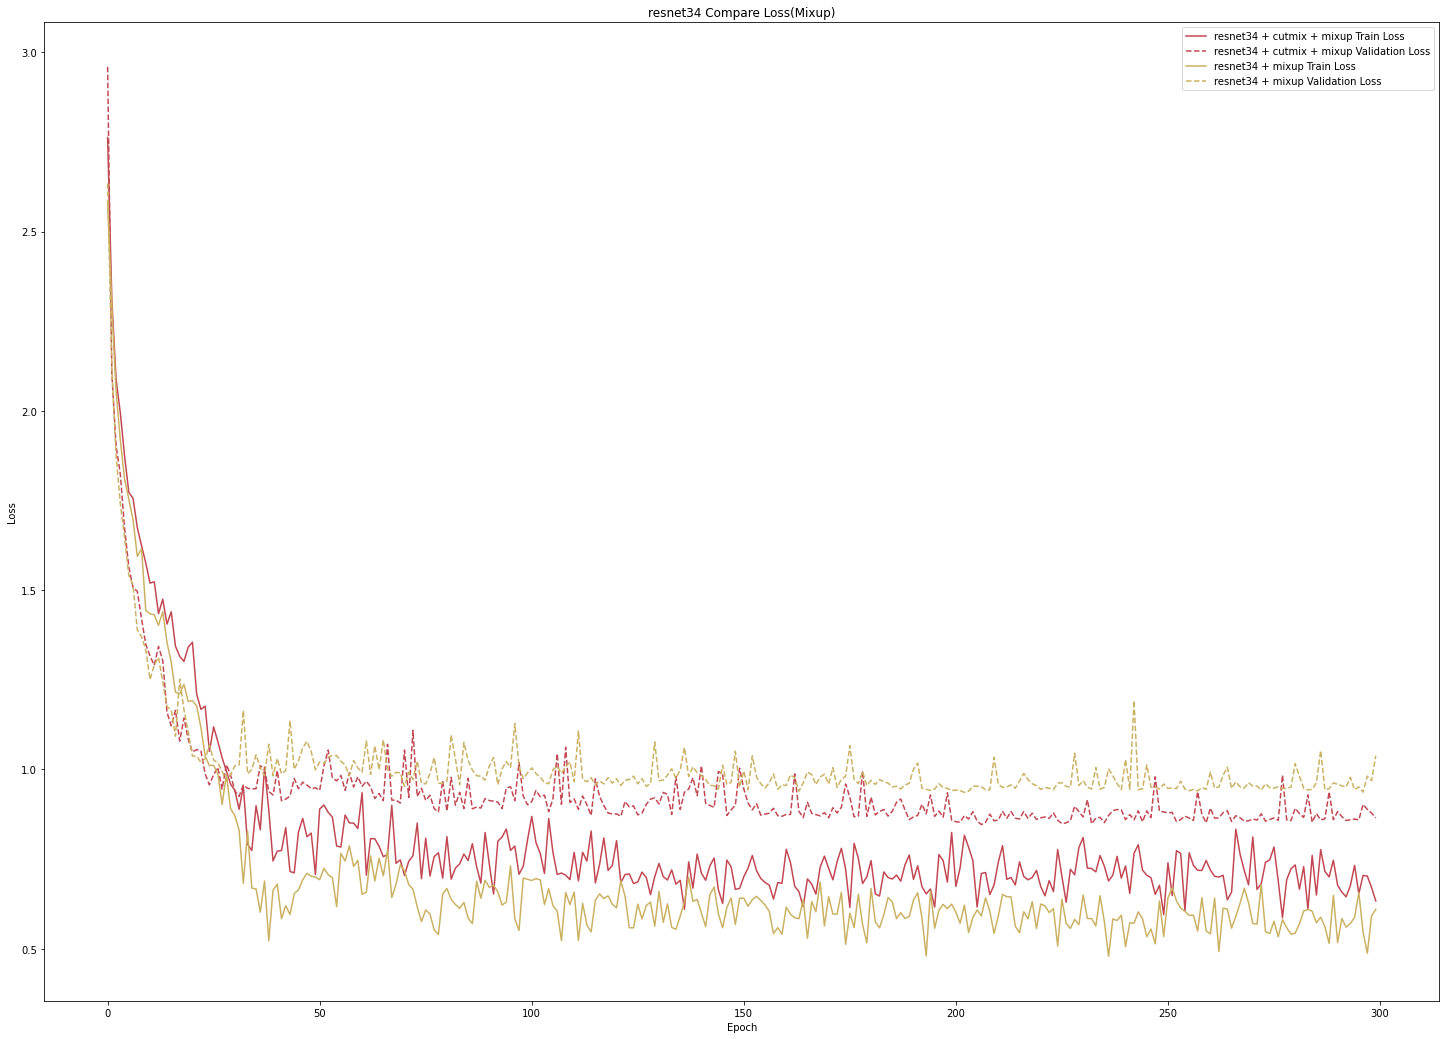

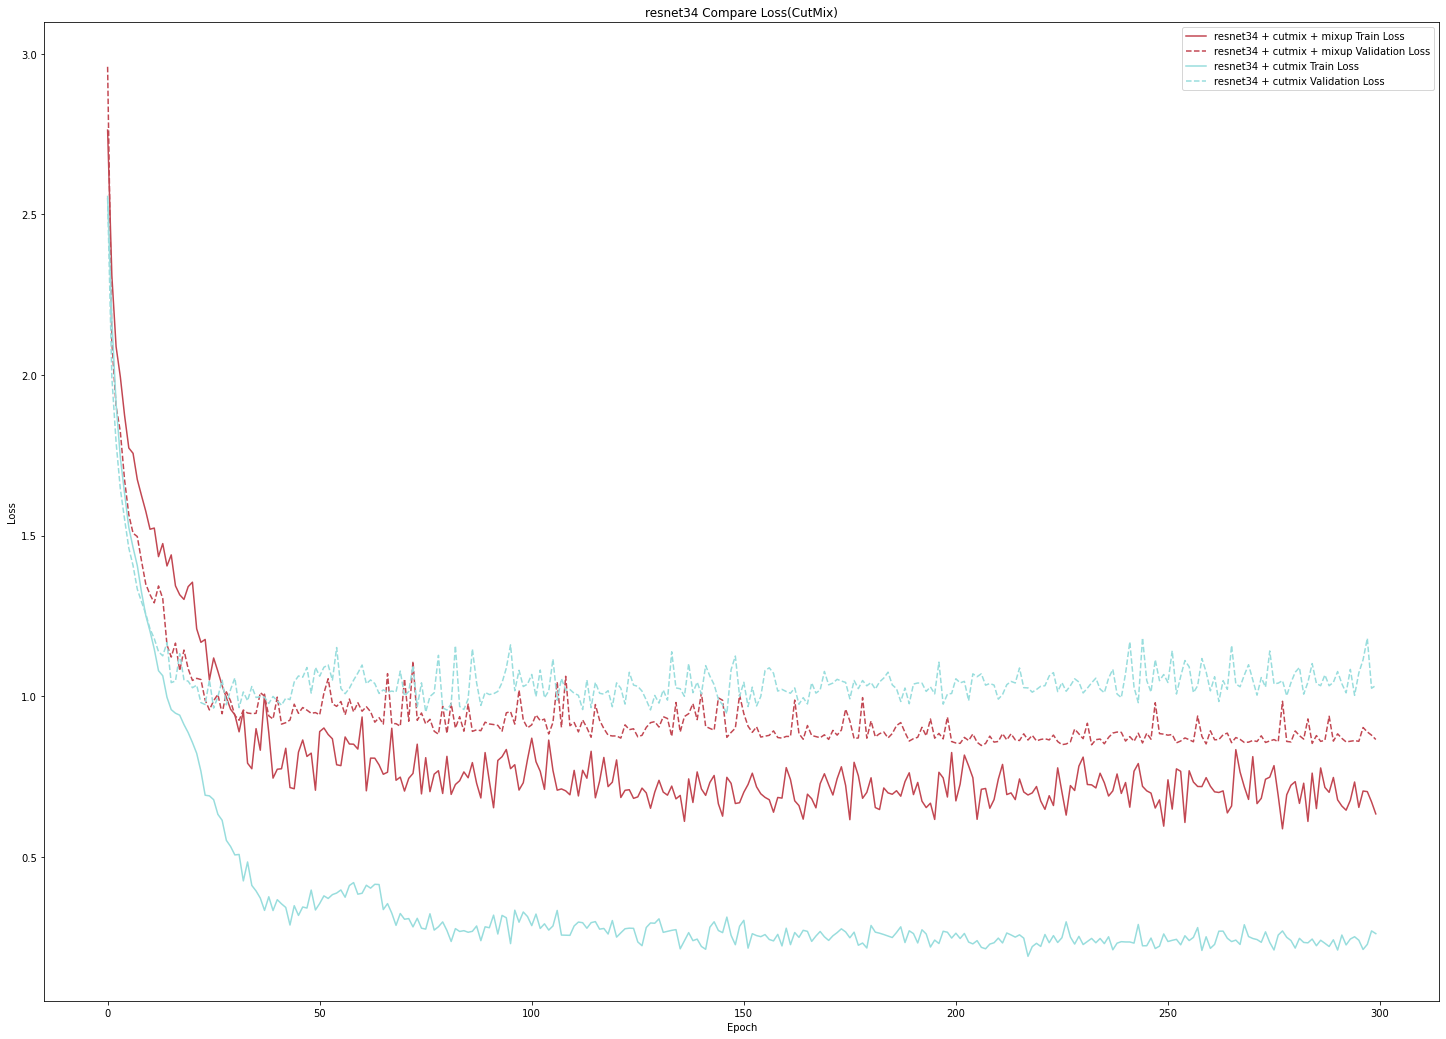

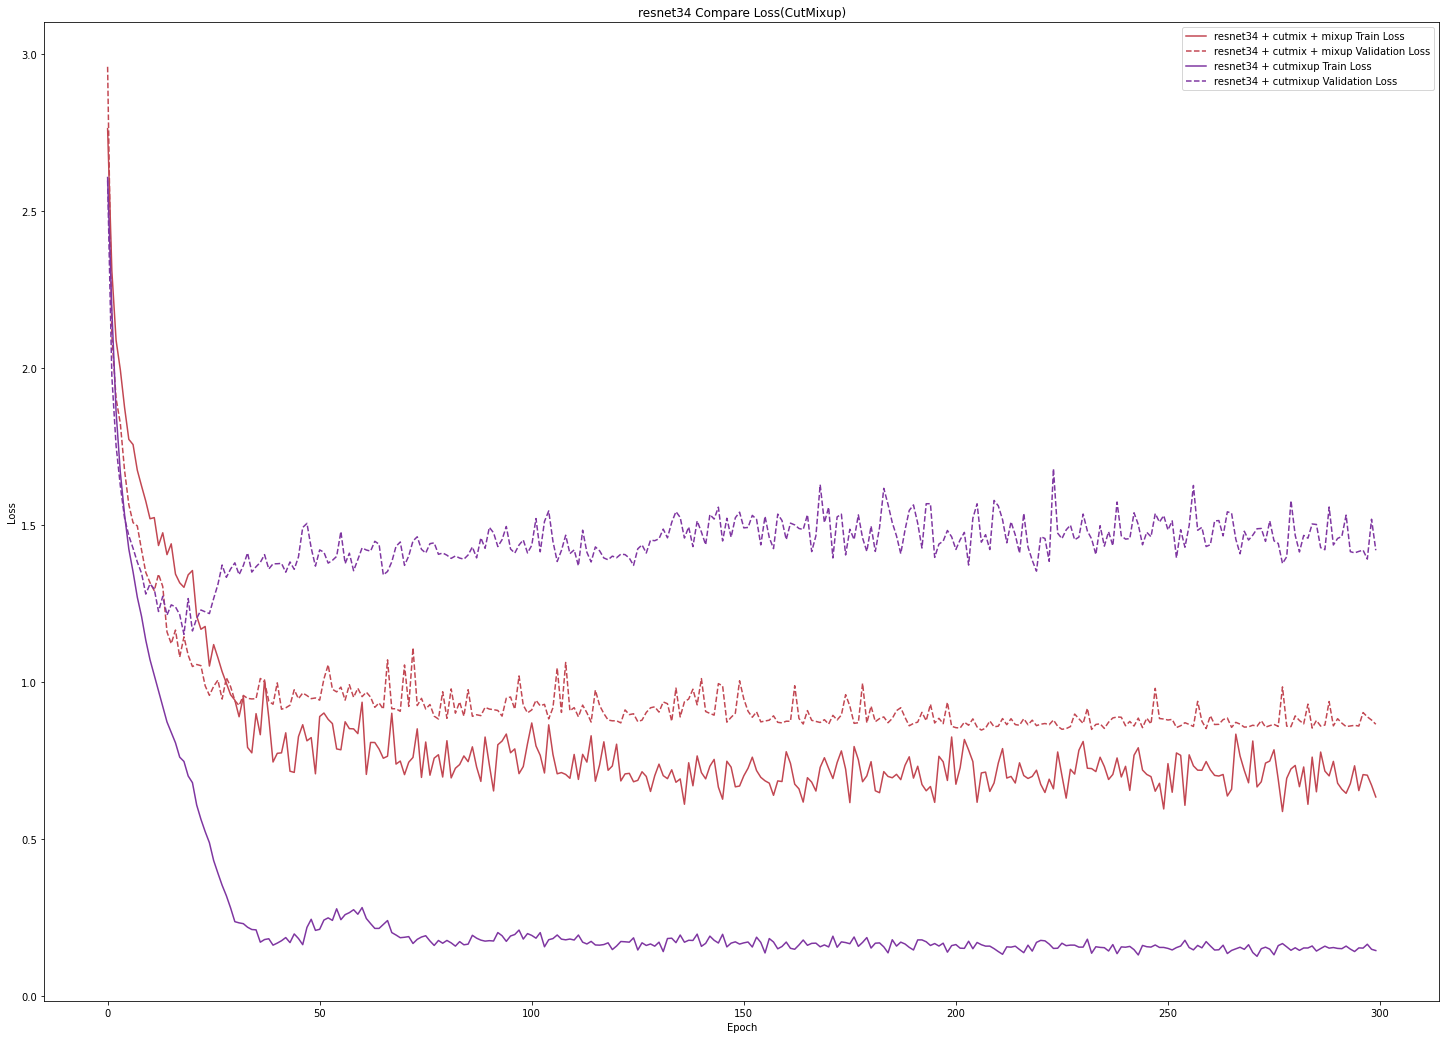

In [ ]:
print("--main--")
main_train_last_top1_acc,main_val_last_top1_acc,main_pytorch_total_params,main_train_loss_history,main_train_correct_history,main_validation_loss_history,main_validation_correct_history=main_main()
print("--ori--")
original_train_last_top1_acc,original_val_last_top1_acc,original_pytorch_total_params,original_train_loss_history,original_train_correct_history,original_validation_loss_history,original_validation_correct_history=ori_main()
print("--mixup--")
mixup_train_last_top1_acc,mixup_val_last_top1_acc,mixup_pytorch_total_params,mixup_train_loss_history,mixup_train_correct_history,mixup_validation_loss_history,mixup_validation_correct_history=mixup_main()
print("--cutmix--")
cutmix_train_last_top1_acc,cutmix_val_last_top1_acc,cutmix_pytorch_total_params,cutmix_train_loss_history,cutmix_train_correct_history,cutmix_validation_loss_history,cutmix_validation_correct_history=cutmix_main()
print("--cutmixup--")
cutmixup_train_last_top1_acc,cutmixup_val_last_top1_acc,cutmixup_pytorch_total_params,cutmixup_train_loss_history,cutmixup_train_correct_history,cutmixup_validation_loss_history,cutmixup_validation_correct_history=cutmixup_main()

print ("{:<30} {:<30} {:<30} {:<30}".format('Model','Train Last Top1 Accuracy','Validation Last Top1 Accuracy','Total Parameters'))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}',original_train_last_top1_acc,original_val_last_top1_acc,original_pytorch_total_params))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}+cutmix',cutmix_train_last_top1_acc,cutmix_val_last_top1_acc,cutmix_pytorch_total_params))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}+mixup',mixup_train_last_top1_acc,mixup_val_last_top1_acc,mixup_pytorch_total_params))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}+cutmixup',cutmixup_train_last_top1_acc,cutmixup_val_last_top1_acc,cutmixup_pytorch_total_params))
print ("{:<30} {:<30} {:<30} {:<30}".format(f'{MODELNAME}+cutmix+mixup',main_train_last_top1_acc,main_val_last_top1_acc,main_pytorch_total_params))


X1 = np.arange(len(main_train_correct_history))
train_y1 = np.array(main_train_correct_history)
val_y1 = np.array(main_validation_correct_history)
train_ori_y1 = np.array(original_train_correct_history)
val_ori_y1 = np.array(original_validation_correct_history)
train_mixup_y1 = np.array(mixup_train_correct_history)
val_mixup_y1 = np.array(mixup_validation_correct_history)
train_cutmix_y1 = np.array(cutmix_train_correct_history)
val_cutmix_y1 = np.array(cutmix_validation_correct_history)
train_cutmixup_y1 = np.array(cutmixup_train_correct_history)
val_cutmixup_y1 = np.array(cutmixup_validation_correct_history)

X2 = np.arange(len(main_train_loss_history))
train_y2 = np.array(main_train_loss_history)
val_y2 = np.array(main_validation_loss_history)
train_ori_y2 = np.array(original_train_loss_history)
val_ori_y2 = np.array(original_validation_loss_history)
train_mixup_y2 = np.array(mixup_train_loss_history)
val_mixup_y2 = np.array(mixup_validation_loss_history)
train_cutmix_y2 = np.array(cutmix_train_loss_history)
val_cutmix_y2 = np.array(cutmix_validation_loss_history)
train_cutmixup_y2 = np.array(cutmixup_train_loss_history)
val_cutmixup_y2 = np.array(cutmixup_validation_loss_history)


plt.figure(1,figsize=IMGSIZE)
plt.plot(X1,train_y1,label=f"{MODELNAME} + cutmix + mixup Train Accuracy",color='#C24752', linestyle='-')
plt.plot(X1,val_y1,label=f"{MODELNAME} + cutmix + mixup Validation Accuracy",color='#C24752', linestyle='--')
plt.plot(X1,train_ori_y1,label=f"{MODELNAME} Train Accuracy",color='#3B7DB0', linestyle='-')
plt.plot(X1,val_ori_y1,label=f"{MODELNAME} Validation Accuracy",color='#3B7DB0', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{MODELNAME} Compare Accuracy(Original)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Accuracy_Original.png")

plt.figure(2,figsize=IMGSIZE)
plt.plot(X1,train_y1,label=f"{MODELNAME} + cutmix + mixup Train Accuracy",color='#C24752', linestyle='-')
plt.plot(X1,val_y1,label=f"{MODELNAME} + cutmix + mixup Validation Accuracy",color='#C24752', linestyle='--')
plt.plot(X1,train_mixup_y1,label=f"{MODELNAME} + mixup Train Accuracy",color='#CBB162', linestyle='-')
plt.plot(X1,val_mixup_y1,label=f"{MODELNAME} + mixup Validation Accuracy",color='#CBB162', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{MODELNAME} Compare Accuracy(Mixup)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Accuracy_Mixup.png")

plt.figure(3,figsize=IMGSIZE)
plt.plot(X1,train_y1,label=f"{MODELNAME} + cutmix + mixup Train Accuracy",color='#C24752', linestyle='-')
plt.plot(X1,val_y1,label=f"{MODELNAME} + cutmix + mixup Validation Accuracy",color='#C24752', linestyle='--')
plt.plot(X1,train_cutmix_y1,label=f"{MODELNAME} + cutmix Train Accuracy",color='#98DDDD', linestyle='-')
plt.plot(X1,val_cutmix_y1,label=f"{MODELNAME} + cutmix Validation Accuracy",color='#98DDDD', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{MODELNAME} Compare Accuracy(CutMix)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Accuracy_CutMix.png")

plt.figure(4,figsize=IMGSIZE)
plt.plot(X1,train_y1,label=f"{MODELNAME} + cutmix + mixup Train Accuracy",color='#C24752', linestyle='-')
plt.plot(X1,val_y1,label=f"{MODELNAME} + cutmix + mixup Validation Accuracy",color='#C24752', linestyle='--')
plt.plot(X1,train_cutmixup_y1,label=f"{MODELNAME} + cutmixup Train Accuracy",color='#7F36A1', linestyle='-')
plt.plot(X1,val_cutmixup_y1,label=f"{MODELNAME} + cutmixup Validation Accuracy",color='#7F36A1', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{MODELNAME} Compare Accuracy(CutMixup)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Accuracy_CutMixup.png")

plt.figure(5,figsize=IMGSIZE)
plt.plot(X2,train_y2,label=f"{MODELNAME} + cutmix + mixup Train Loss",color='#C24752', linestyle='-')
plt.plot(X2,val_y2,label=f"{MODELNAME} + cutmix + mixup Validation Loss",color='#C24752', linestyle='--')
plt.plot(X2,train_ori_y2,label=f"{MODELNAME} Train Loss",color='#3B7DB0', linestyle='-')
plt.plot(X2,val_ori_y2,label=f"{MODELNAME} Validation Loss",color='#3B7DB0', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{MODELNAME} Compare Loss(Original)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Loss_Original.png")

plt.figure(6,figsize=IMGSIZE)
plt.plot(X2,train_y2,label=f"{MODELNAME} + cutmix + mixup Train Loss",color='#C24752', linestyle='-')
plt.plot(X2,val_y2,label=f"{MODELNAME} + cutmix + mixup Validation Loss",color='#C24752', linestyle='--')
plt.plot(X2,train_mixup_y2,label=f"{MODELNAME} + mixup Train Loss",color='#CBB162', linestyle='-')
plt.plot(X2,val_mixup_y2,label=f"{MODELNAME} + mixup Validation Loss",color='#CBB162', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{MODELNAME} Compare Loss(Mixup)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Loss_Mixup.png")

plt.figure(7,figsize=IMGSIZE)
plt.plot(X2,train_y2,label=f"{MODELNAME} + cutmix + mixup Train Loss",color='#C24752', linestyle='-')
plt.plot(X2,val_y2,label=f"{MODELNAME} + cutmix + mixup Validation Loss",color='#C24752', linestyle='--')
plt.plot(X2,train_cutmix_y2,label=f"{MODELNAME} + cutmix Train Loss",color='#98DDDD', linestyle='-')
plt.plot(X2,val_cutmix_y2,label=f"{MODELNAME} + cutmix Validation Loss",color='#98DDDD', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{MODELNAME} Compare Loss(CutMix)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Loss_CutMix.png")

plt.figure(8,figsize=IMGSIZE)
plt.plot(X2,train_y2,label=f"{MODELNAME} + cutmix + mixup Train Loss",color='#C24752', linestyle='-')
plt.plot(X2,val_y2,label=f"{MODELNAME} + cutmix + mixup Validation Loss",color='#C24752', linestyle='--')
plt.plot(X2,train_cutmixup_y2,label=f"{MODELNAME} + cutmixup Train Loss",color='#7F36A1', linestyle='-')
plt.plot(X2,val_cutmixup_y2,label=f"{MODELNAME} + cutmixup Validation Loss",color='#7F36A1', linestyle='--')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{MODELNAME} Compare Loss(CutMixup)')
plt.savefig(f"{IMGPATH}/{MODELNAME}_Compare_Loss_CutMixup.png")
    

## Test

In [ ]:
# -*- coding: utf-8 -*-

# import argparse
from random import sample
import pandas as pd


def eval():
    model1 = resnet34()
    model2 = resnet34()
    model3 = resnet34()
    model4 = resnet34()
    model5 = resnet34()
    model1 = model1.cuda() if IsGPU else model1
    model2 = model2.cuda() if IsGPU else model2
    model3 = model3.cuda() if IsGPU else model3
    model4 = model4.cuda() if IsGPU else model4
    model5 = model5.cuda() if IsGPU else model5
    model1.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}.pth'))
    model2.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}_cutmix.pth'))
    model3.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}_mixup.pth'))
    model4.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}_original.pth'))
    model5.load_state_dict(torch.load(f'{MODELPATH}/model_weight_{MODELNAME}_cutmixup.pth'))
    
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()
    model5.eval()

    total = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0
    correct4 = 0
    correct5 = 0
    # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
    print('Evaluate...')
    with torch.no_grad():
        for i, (input, target) in enumerate(testloader):
            input = input.cuda() if IsGPU else input
            target = target.cuda() if IsGPU else target
            # 신경망에 이미지를 통과시켜 출력을 계산합니다
            output1 = model1(input)
            output2 = model2(input)
            output3 = model3(input)
            output4 = model4(input)
            output5 = model5(input)
            _, predictions1 = torch.max(output1, 1)
            _, predictions2 = torch.max(output2, 1)
            _, predictions3 = torch.max(output3, 1)
            _, predictions4 = torch.max(output4, 1)
            _, predictions5 = torch.max(output5, 1)
            # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
            total += target.size(0)
            correct1 += (predictions1 == target).sum().item()
            correct2 += (predictions2 == target).sum().item()
            correct3 += (predictions3 == target).sum().item()
            correct4 += (predictions4 == target).sum().item()
            correct5 += (predictions5 == target).sum().item()
        

    print(f'Accuracy of cutmix and mixup {MODELNAME} on the 10000 test images: {100 * correct1 / total:.2f} %')
    print(f'Accuracy of cutmix {MODELNAME} on the 10000 test images: {100 * correct2 / total:.2f} %')
    print(f'Accuracy of mixup {MODELNAME} on the 10000 test images: {100 * correct3 / total:.2f} %')
    print(f'Accuracy of original {MODELNAME} on the 10000 test images: {100 * correct4 / total:.2f} %')
    print(f'Accuracy of cutmixup {MODELNAME} on the 10000 test images: {100 * correct5 / total:.2f} %')


if __name__ == "__main__":
    eval()

Evaluate...
Accuracy of cutmix and mixup resnet34 on the 10000 test images: 73.95 %
Accuracy of cutmix resnet34 on the 10000 test images: 74.54 %
Accuracy of mixup resnet34 on the 10000 test images: 72.96 %
Accuracy of original resnet34 on the 10000 test images: 65.50 %
Accuracy of cutmixup resnet34 on the 10000 test images: 67.78 %
